In [1]:
from os.path import join
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import FactorAnalyzer
import scipy.stats as stats
#plt.style.use("apa.mplstyle") #custom matplotlib style

In [2]:
folder_path = "/data/NewsGuard/full-metadata/"
figures_path = "/home/jluehring/newsguard/newsguard-review-paper/figures/"
tables_path = "/home/jluehring/newsguard/newsguard-review-paper/tables/"

# Dataset construction

In [3]:
csv_files = [f for f in os.listdir(folder_path) \
                if f.endswith(".csv") \
                and "2024" not in f]

df_total = pd.DataFrame()
for csv in csv_files: #taking all files in the folder
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    # taking name of file, removing the extension and "metadata-"
    df["file_date"]=csv.split(".")[0].split("-")[1]
    # converting file_date to datetime, with format YYYYMMDD00
    df["file_date"]=pd.to_datetime(df["file_date"], 
                                   format="%Y%m%d%H")
    df_total = pd.concat([df_total, df], axis=0)

In [4]:
csv_files = [f for f in os.listdir(folder_path) \
                if f.endswith("1501.csv") \
                and "2024" not in f] #taking only mid-month 
df15 = pd.DataFrame()
for csv in csv_files:
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    df["file_date"]=csv.split(".")[0].split("-")[1]
    df["file_date"]=pd.to_datetime(df["file_date"], 
                                   format="%Y%m%d%H")
    df15 = pd.concat([df15, df], axis=0)

In [5]:
csv_files = [f for f in os.listdir(folder_path) \
                if f.endswith("0201.csv") \
                and "2024" not in f] 
df02 = pd.DataFrame()
for csv in csv_files:
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    df["file_date"]=csv.split(".")[0].split("-")[1]
    df["file_date"]=pd.to_datetime(df["file_date"], 
                                   format="%Y%m%d%H")
    df02 = pd.concat([df02, df], axis=0)

In [6]:
most_recent = df15[df15["file_date"] == df15["file_date"].max()]
first = df15[df15["file_date"] == df15["file_date"].min()]

print(f'In the most recent file, there are {len(most_recent)} entries, '
      f'with {most_recent["UUID"].nunique()} rating IDs '
      f'and {most_recent["Domain"].nunique()} domains.')

print(f'In the first file, there are {len(first)} entries, '
      f'with {first["UUID"].nunique()} IDs '
      f'and {first["Domain"].nunique()} domains.')

In the most recent file, there are 11314 entries, with 6598 rating IDs and 9946 domains.
In the first file, there are 2647 entries, with 2647 IDs and 2641 domains.


In [7]:
rating_counts = most_recent.Rating\
    .value_counts(normalize=False)\
    .reset_index()\
    .rename(columns={"index":"Rating", "Rating":"Count"})

rating_countsp = most_recent.Rating\
    .value_counts(normalize=True)\
    .reset_index()\
    .rename(columns={"index":"Rating", "Rating":"Percent"})

ratings = pd.merge(rating_counts, rating_countsp, 
                   on="Rating")

rating_mean = most_recent\
    .groupby("Rating").Score\
    .mean()\
    .reset_index()\
    .rename(columns={"Score":"Mean"})

pd.merge(ratings, rating_mean, on="Rating")

,Rating,Count,Percent,Mean
0,T,6651,0.587856,87.370320
1,N,4007,0.354163,26.107187
2,FL,530,0.046845,NaN
3,P,63,0.005568,NaN
4,S,63,0.005568,NaN


In [8]:
most_recent[most_recent.Rating == "P"].Domain.unique()[:3]

array(['youtube.com', 'youtu.be', 'dailymotion.com'], dtype=object)

In [9]:
most_recent[most_recent.Rating == "S"].Domain.unique()[:5]

array(['bassesaintonge.fr', 'secretnews.fr', 'chaser.com.au',
       'prankyourfriends.com', 'breakingnews247.net'], dtype=object)

In [10]:
most_recent[most_recent.Rating == "FL"].Domain.unique()[:10]

array(['letradamus.es', 'mundodelcafe.es', 'mamamusical.aarg.ar',
       'ieducaciones.com', 'rimando.click', 'ts2.space',
       'sandraibeleme.com', 'lovethemaldives.com', 'aboutmans.com',
       'healthquotefree.com'], dtype=object)

In [11]:
p_rating = most_recent[most_recent["Rating"] == "P"]
if not p_rating["Score"].isnull().all():
    mean_score = p_rating["Score"].mean(skipna=True)
    print(f"Mean score for rating P: {mean_score}")
else:
    print(f"No scores available for rating P.")

No scores available for rating P.


In [12]:
print(f'Number of rows without Score: {most_recent.Score.isna().sum()}')
print(f'Percentage: {round(most_recent.Score.isna().sum()/len(most_recent)*100,2)}%')

Number of rows without Score: 656
Percentage: 5.8%


## How volatile are trustworthiness ratings?

### Coverage

In [13]:
print(f'In the most recent df, there are {len(most_recent[most_recent["Score"].notnull()])} rated domains while there are {len(first[first["Score"].notnull()])} in the first version of the database.')
print(f'The number of entries has grown by {round((len(most_recent)/len(first)-1)*100,2)}%')

In the most recent df, there are 10658 rated domains while there are 2615 in the first version of the database.
The number of entries has grown by 327.43%


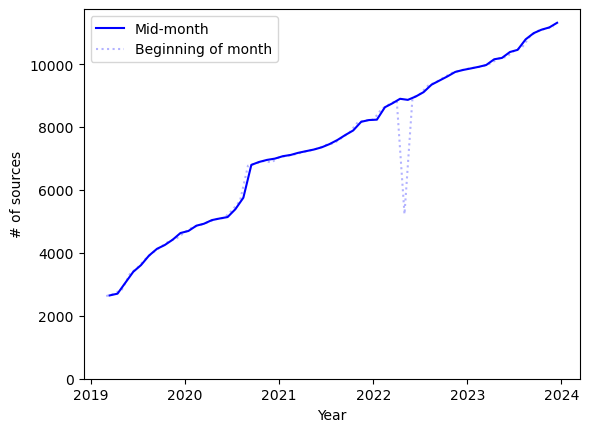

In [14]:
#counting number of ratings for sampling mid-month
counts_15 = df15.groupby(df15.file_date)\
    .size()\
    .reset_index(name="Counts")

#counting number of ratings for sampling beginning of month
counts_02 = df02.groupby(df02.file_date)\
    .size()\
    .reset_index(name="Counts")

plt.plot(counts_15["file_date"], 
         counts_15["Counts"], 
         color="blue",
         label="Mid-month")
plt.plot(counts_02["file_date"], 
         counts_02["Counts"], 
         color="blue", 
         label="Beginning of month", 
         alpha=0.3, 
         linestyle="dotted")
plt.ylim(0)
plt.xlabel("Time (years)")
plt.ylabel("Number of ratings")
#plt.xticks(rotation=20)
plt.legend()
plt.savefig(join(figures_path,
                 "f1-sources_over_time.png"), 
                 dpi=300)
plt.show()

### Added and removed sources

In [15]:
domain_changes = {}
#getting list of unique months to iterate through
unique_months = df15.sort_values("file_date")["file_date"]\
                    .unique()

for i in range(1, len(unique_months)): #iterate through months
    current_month = unique_months[i] #set as current months
    previous_month = unique_months[i - 1] #set month minus one as previous month
    
    #compare domains from current month to previous month
    added_month = set(df15[df15["file_date"] == current_month]["Domain"].tolist())\
        - set(df15[df15["file_date"] == previous_month]["Domain"].tolist())
    removed_month = set(df15[df15["file_date"] == previous_month]["Domain"].tolist())\
        - set(df15[df15["file_date"] == current_month]["Domain"].tolist())
    domain_changes[current_month] = added_month, removed_month

In [16]:
data = []
for date, (added, removed) in domain_changes.items():
    data.append({"Date": date, 
                 "Added": len(added), 
                 "Removed": len(removed)})

domain_changes_df = pd.DataFrame(data)

In [17]:
print(f'Total number of added sources: {domain_changes_df["Added"].sum()}')
print(f'Total number of removed sources: {domain_changes_df["Removed"].sum()}')

Total number of added sources: 7937
Total number of removed sources: 632


In [18]:
print(f'Average number of added sources per month: {domain_changes_df["Added"].mean()}')
print(f'Average number of removed sources per month: {domain_changes_df["Removed"].mean()}')

Average number of added sources per month: 141.73214285714286
Average number of removed sources per month: 11.285714285714286


### Duplicates

In [19]:
#extracting duplicated domains
dup_domains = \
    most_recent[most_recent\
                .duplicated(subset="Domain", 
                            keep=False)]

#looking at only relevant columns
dup_domains["Domain", "Country", "Language", "Score"]\
    .head(10)

,Domain,Country,Language,Score
14,christianophobie.fr,FR,fr,57.0
15,christianophobie.fr,ALL,en,57.0
17,famillessanteprevention.org,FR,fr,27.5
18,famillessanteprevention.org,ALL,en,27.5
19,editorialedomani.it,IT,it,75.0
20,editorialedomani.it,ALL,en,75.0
154,quotidianosanita.it,IT,it,82.5
155,quotidianosanita.it,ALL,en,82.5
156,dire.it,IT,it,75.0
157,dire.it,ALL,en,75.0


In [20]:
#counting if the score is the same for domains
dup_domains \
    .groupby("Domain").Score \
    .nunique() \
    .reset_index(name="nunique") \
    .sort_values(by="nunique", 
                 ascending=False)

,Domain,nunique
1,2020news.de,2
812,msn.com,2
1272,vice.com,2
0,100giornidaleoni.it,1
895,ohga.it,1
...,...,...
237,der-postillon.com,0
1110,scienceinfo.fr,0
1076,rumble.com,0
918,ots.at,0


In [21]:
dup_domains[dup_domains["Domain"] == "2020news.de"]

,Domain,Country,Language,Score
353,2020news.de,DE,de,7.5
354,2020news.de,ALL,en,7.5
5943,2020news.de,IT,it,20.0


In [22]:
dup_domains[dup_domains["Domain"] == "msn.com"]

,Domain,Country,Language,Score
7184,msn.com,ALL,en,100.0
7185,msn.com,FR,fr,100.0
7198,msn.com,IT,it,87.5
7485,msn.com,US,en,100.0


## Trustworthiness distribution

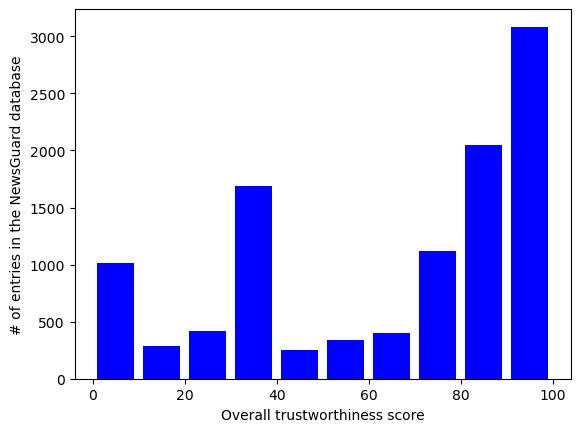

In [23]:
most_recent["Score"].hist(bins=10, 
                          color="blue", 
                          rwidth=0.8, 
                          grid=False)
plt.xlabel("Trustworthiness")
plt.ylabel("Number of ratings")
plt.savefig(join(figures_path,
                "f2-trustworthiness_distribution.png"), 
                dpi=300)
plt.show()

In [24]:
df15["file_year"] = pd.to_datetime(df15.file_date)\
    .dt.to_period("Y")
df15["file_month"] = pd.to_datetime(df15.file_date)\
    .dt.to_period("M")
df15.groupby("file_year").Score.value_counts()

file_year  Score
2019       100.0    9525
           87.5     3987
           95.0     2674
           82.5     2606
           5.0      2605
                    ... 
2023       72.0       34
           45.0       20
           67.0       18
           52.5       12
           27.0        8
Name: Score, Length: 303, dtype: int64

In [25]:
year_scores = df15\
    .groupby("file_year")["Score"]\
    .agg(["mean", "std", "min", "max"])\
    .reset_index()
print(year_scores)

  file_year       mean        std  min    max
0      2019  71.767972  33.287474  0.0  100.0
1      2020  66.001125  34.087030  0.0  100.0
2      2021  63.692641  33.858325  0.0  100.0
3      2022  65.200969  33.158941  0.0  100.0
4      2023  64.532554  32.412332  0.0  100.0


In [26]:
month_scores = df15\
    .groupby("file_month")["Score"]\
    .agg(["mean", "std", "min", "max"])\
    .reset_index()
#print first and last entry
print(month_scores.head(1))
print(month_scores.tail(1))

  file_month       mean        std  min    max
0    2019-03  70.786424  35.328616  0.0  100.0
   file_month       mean        std  min    max
56    2023-12  64.337728  32.294397  0.0  100.0


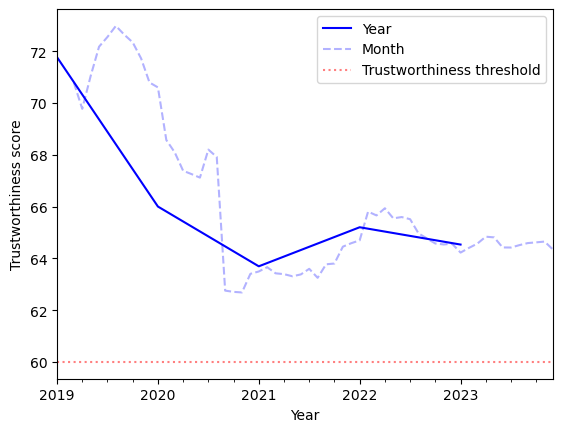

In [27]:
df15.groupby(df15.file_year).Score\
    .mean()\
    .plot(color="blue", label="Year")
df15.groupby(df15.file_month).Score\
    .mean()\
    .plot(color="blue", label="Month",
            alpha=0.3, linestyle="--")
plt.xlabel("Time (years vs months)")
plt.ylabel("Trustworthiness")
plt.axhline(y=60, 
            color= "red", 
            linestyle="dotted", 
            alpha=0.5, 
            label="Trustworthiness threshold")
plt.legend()
plt.savefig(join(figures_path,
                 "scores_over_time.png"), 
                 dpi=300)
plt.show()

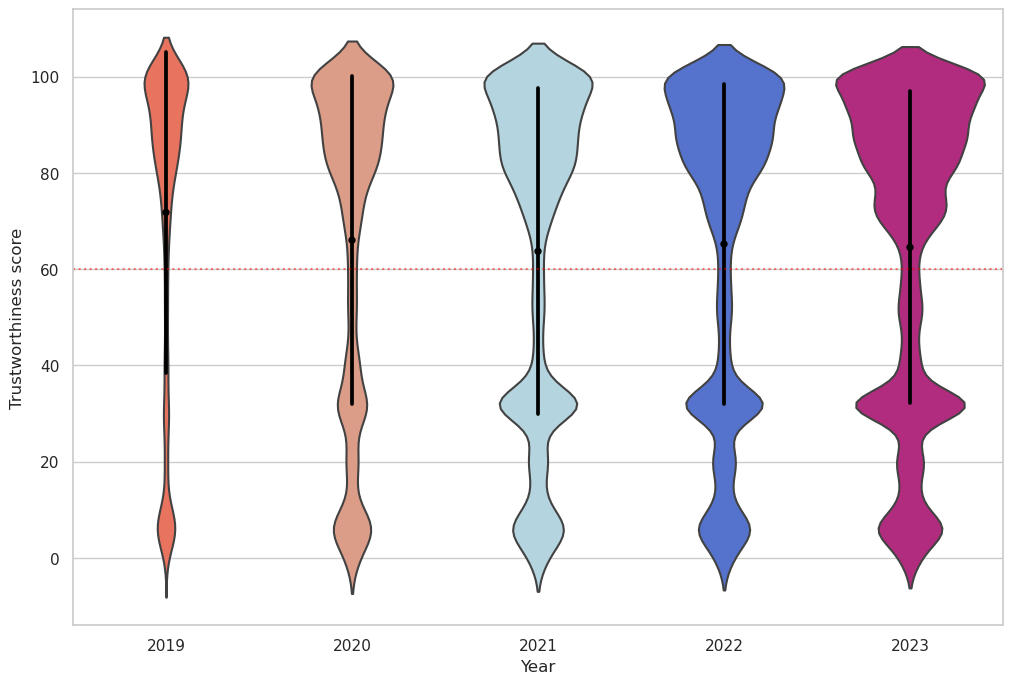

In [28]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

#selected_ratings = ["T", "N"]
#df_selected_ratings = df15[df15["Rating"].isin(selected_ratings)]
year_colors = ["tomato", "darksalmon", "lightblue", "royalblue", "mediumvioletred"]
#year_colors_alpha = [color + "90" for color in year_colors] 

sns.violinplot(x="file_year", 
               y="Score",
               scale="count",
               data=df15,
               inner=None,
               palette=year_colors)

sns.pointplot(
    data=df15, 
    y="Score", 
    x="file_year", 
    estimator="mean",
    errorbar="sd",   
    color="black",  #white
    join=False,  
    markers="o",
    scale=0.6) 

plt.axhline(y=60, color="red", 
            linestyle="dotted",
            alpha=0.5, 
            label="Trustworthiness threshold")

plt.xlabel("Time (years)")
plt.ylabel("Trustworthiness")

plt.savefig(join(figures_path, 
                 "f3-scores_over_time-violin.png"),
                 dpi=300)
plt.show()

/home/jluehring/miniconda3/envs/twarcing/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


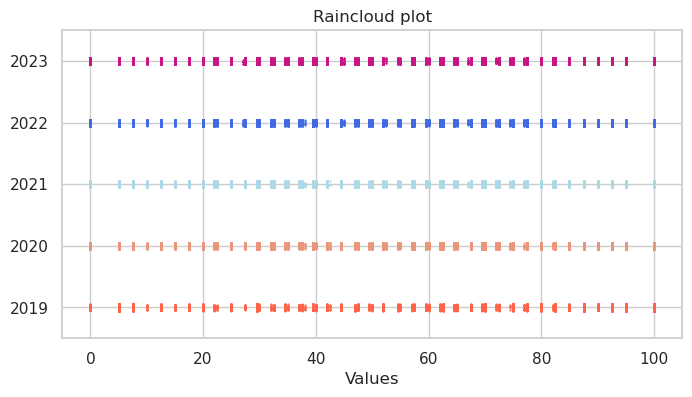

In [29]:
#from https://medium.com/mlearning-ai/getting-started-with-raincloud-plots-in-python-2ea5c2d01c11

grouped_data = [df15[df15["file_year"] == cat]["Score"]\
                .values for cat in df15["file_year"]\
                .unique()]

fig, ax = plt.subplots(figsize=(8, 4))

# Boxplot data
boxplots_colors = ["yellowgreen", "olivedrab", "skyblue", "salmon", "thistle"]

bp = ax.boxplot(grouped_data, 
                patch_artist=True, 
                vert=False)

for patch, color in zip(bp["boxes"], boxplots_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

# Scatterplot data
scatter_colors = ["tomato", "darksalmon", "lightblue", "royalblue", "mediumvioletred"]
for idx, features in enumerate(grouped_data):
    y = np.full(len(features), idx + 1)
    idxs = np.arange(len(y))
    out = y.astype(float)
    out.flat[idxs] += np.random.uniform(low=-.05, 
                                        high=.05, 
                                        size=len(idxs))
    y = out
    plt.scatter(features, y, 
                s=.3, 
                c=scatter_colors[idx])

# Violinplot data
violin_colors = ["yellowgreen", "olivedrab", "skyblue", "salmon", "thistle"]
for idx, features in enumerate(grouped_data):
    # Adjust y-coordinates to prevent overlap with box and scatter plots
    y = np.full(len(features), idx + 1.5)
    vp = ax.violinplot([features], 
                       positions=[idx + 1.5], 
                       points=500, 
                       showmeans=False, 
                       showextrema=False, 
                       showmedians=False, 
                       vert=False)
    
    for b in vp["bodies"]:
        b.set_color(violin_colors[idx])

plt.yticks(np.arange(1, len(grouped_data) + 1, 1), 
           df15["file_year"].unique())  
plt.xlabel("Values")
plt.title("Raincloud plot")
plt.show()

### By added vs. removed sources

In [30]:
domain_changes_df = \
    domain_changes_df\
        .melt(id_vars="Date",
              value_vars=["Added", "Removed"],
              var_name="Change",
              value_name="Count")

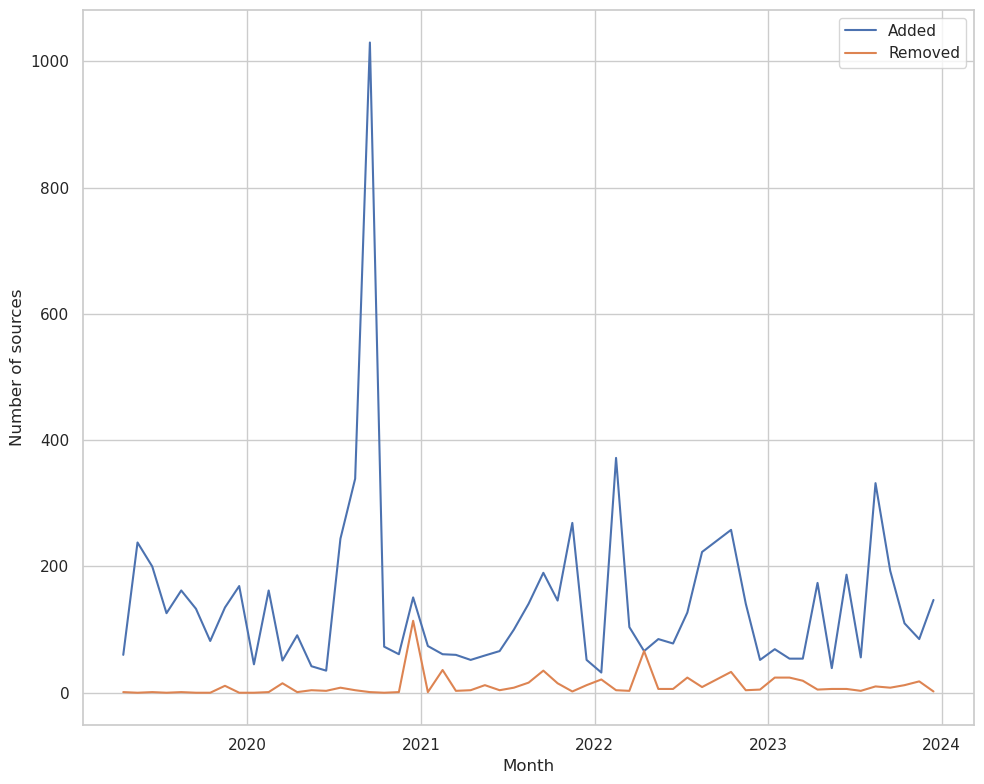

In [31]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=domain_changes_df,
             x="Date",
             y="Count",
             hue="Change")

plt.xlabel("Time (months)")
plt.ylabel("Number of sources") 
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
added_means = []
removed_means = []
added_sds = []
removed_sds = []
months = []

for date in domain_changes.keys():
    added_sources = df15[df15.Domain.isin(domain_changes[date][0])]
    removed_sources = df15[df15.Domain.isin(domain_changes[date][1])]

    added_mean = added_sources["Score"].mean()
    removed_mean = removed_sources["Score"].mean()
    added_sd = added_sources["Score"].std()
    removed_sd = removed_sources["Score"].std()

    added_means.append(added_mean)
    removed_means.append(removed_mean)
    added_sds.append(added_sd)
    removed_sds.append(removed_sd)
    months.append(date)

added_df = pd.DataFrame({
    "Date": months,
    "Added_Mean": added_means,
    "Added_SD": added_sds})

removed_df = pd.DataFrame({
    "Date": months,
    "Removed_Mean": removed_means,
    "Removed_SD": removed_sds})

added_df["Change"] = "Added"
added_df = added_df\
            .rename(
                columns={
                    "Added_Mean": "Mean", 
                    "Added_SD": "SD"})

removed_df["Change"] = "Removed"
removed_df = removed_df\
            .rename(
                columns={
                    "Removed_Mean": "Mean", 
                    "Removed_SD": "SD"})

averages_df = pd.concat([added_df, removed_df])

domain_changes_df = \
    domain_changes_df\
        .merge(averages_df, 
               on=["Date", "Change"])

In [33]:
domain_changes_df[domain_changes_df["Change"] == "Added"]\
    .sort_values(by="Count", 
                 ascending=False)\
    .head(3)

,Date,Change,Count,Mean,SD
17,2020-09-15 01:00:00,Added,1030,35.274797,14.078383
34,2022-02-15 01:00:00,Added,372,88.108452,15.757896
16,2020-08-15 01:00:00,Added,339,60.797994,35.762535


In [34]:
print(f'Added sources: '
        f'Mean={round(added_df["Mean"].mean(), 2)}, '
        f'SD={round(added_df["SD"].mean(), 2)}')
print(f'Removed sources: '
        f'Mean={round(removed_df["Mean"].mean(), 2)}, '
        f'SD={round(removed_df["SD"].mean(), 2)}')

Added sources: Mean=61.59, SD=27.62
Removed sources: Mean=55.53, SD=19.08


### By country

In [35]:
country_count = df15\
    .groupby("file_date")\
        .agg(
            Count=("Country", 
                   "nunique"),
            Score=("Score", 
                   "mean"),
            SD=("Score", 
                "std"),
            Countries=("Country", lambda x: ", ".join(sorted(x.unique())))
            )\
    .reset_index()

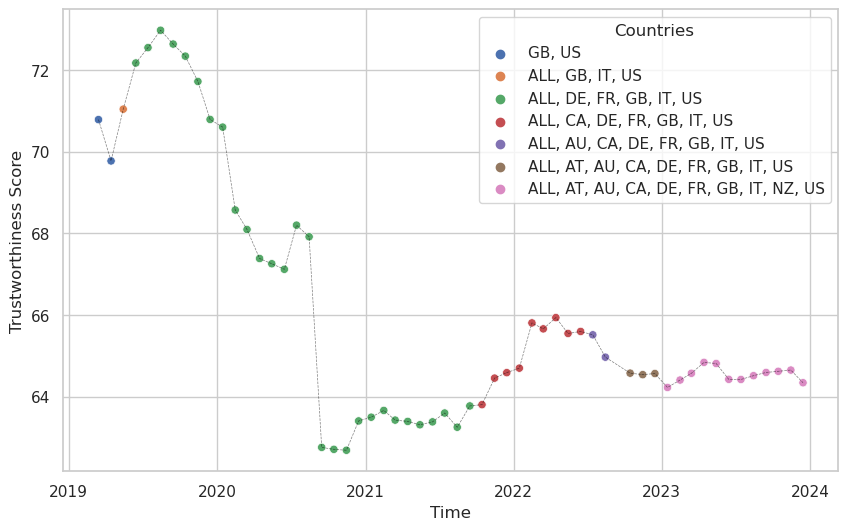

In [36]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=country_count, 
    x="file_date", 
    y="Score", 
    color="black", 
    linestyle="--", 
    linewidth=0.5,
    alpha=0.5)

sns.scatterplot(data=country_count, 
                x="file_date", 
                y="Score", 
                hue="Countries")

plt.xlabel("Time (years)")
plt.ylabel("Trustworthiness")
plt.grid(True)
plt.legend(title="Countries")

plt.savefig(join(figures_path,
                    "fa1-scores_by_country.png"), 
                    dpi=300)
plt.show()

In [37]:
added_2020 = set(domain_changes[np.datetime64('2020-09-15T01:00:00.000000000')][0])
df_20_09 = df15[df15["file_month"] == "2020-09"]
added_sources = \
    df_20_09[df_20_09["Domain"]\
                  .isin(added_2020)]
added_sources["Country"]\
    .value_counts()

US     1015
ALL      15
IT        6
DE        5
FR        4
Name: Country, dtype: int64

### Updates

In [38]:
df15["Last Updated"]=pd.to_datetime(df15["Last Updated"],unit="ms")
df15["Last Updated"].head(3)

0   2018-07-20 14:03:17.020
1   2018-07-20 14:03:21.115
2   2018-07-20 14:03:25.883
Name: Last Updated, dtype: datetime64[ns]

In [39]:
df15_UUID = df15.drop_duplicates(subset="UUID", 
                                 keep="first")
print(f'Without UUID length = {len(df15)}, with UUID = {len(df15_UUID)}.')

Without UUID length = 421870, with UUID = 45294.


In [40]:
domain_updates_sorted = \
    df15_UUID\
        .groupby("Domain")\
        .apply( #group by domain
            lambda x: x.sort_values("Last Updated") #then sort by last updated
        ).reset_index(drop=True) #reset index

domain_updates_sorted.head(3)

,UUID,Domain,Parent Domain,Rating,Score,Last Updated,Country,Language,Does not repeatedly publish false content,Gathers and presents information responsibly,...,ANDROIDAPP,OTHER,Contact Mail Form URL.1,Communities Served,BrandGuard Segments,False Narratives,Does not repeatedly publish false or egregiously misleading content,Has effective practices for correcting errors,file_year,file_month
0,b9704871-32df-4721-881c-2dc6d03d8905,1000logos.net,NaN,FL,NaN,2023-09-27 04:25:20.721,US,en,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2023-10
1,07be0795-9c5e-43ad-932b-e7e0154d5828,100fedup.com,100percentfedup.com,N,7.5,2018-09-08 22:26:33.205,US,en,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,2019-03
2,a7cfbf89-68cf-4a16-9b92-96cbda6cdad5,100fedup.com,100percentfedup.com,N,7.5,2019-10-04 23:22:52.632,US,en,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,2019-10


In [41]:
domain_updates_diff = \
    domain_updates_sorted\
        .groupby("Domain")["Last Updated"]\
        .diff()

In [42]:
mean_diff_per_domain = \
    domain_updates_diff\
        .groupby(domain_updates_sorted["Domain"])\
        .mean()
print(mean_diff_per_domain)

Domain
1000logos.net                                  NaT
100fedup.com              242 days 20:33:44.148500
100giornidaleoni.it    121 days 23:40:35.276333334
100milefreepress.net                           NaT
100percentfedup.com    261 days 09:45:57.592285716
                                   ...            
zonazealots.com           420 days 05:06:58.393000
zt.20minut.ua                                  NaT
zuerst.de              140 days 00:42:35.585571428
zurzeit.at                  0 days 00:00:01.480000
zvw.de                    174 days 13:53:17.657400
Name: Last Updated, Length: 10293, dtype: timedelta64[ns]


In [43]:
mean_diff_per_domain.describe()

count                           8650
mean     279 days 21:57:16.085303828
std      126 days 08:02:28.290090692
min           0 days 00:00:00.955000
25%      186 days 15:18:13.956166666
50%         291 days 07:53:54.314700
75%      388 days 18:15:43.625437500
max        1109 days 19:36:32.340000
Name: Last Updated, dtype: object

In [44]:
print(mean_diff_per_domain[mean_diff_per_domain == mean_diff_per_domain.max()])
print(mean_diff_per_domain[mean_diff_per_domain == mean_diff_per_domain.min()])

Domain
eblida.org   1109 days 19:36:32.340000
Name: Last Updated, dtype: timedelta64[ns]
Domain
nnn.de   0 days 00:00:00.955000
Name: Last Updated, dtype: timedelta64[ns]


In [45]:
domain_updates_sorted["Score_diff"] = domain_updates_sorted\
                                        .groupby("Domain")["Score"]\
                                        .diff()
domain_score_diff = domain_updates_sorted\
                            .groupby("Domain")["Score_diff"]\
                            .mean()

print(f'The average score difference between updates is: '
      f'{domain_score_diff.mean()}, '
      f'SD = {domain_score_diff.std()}.')
print(f'The range of score differences is: '
      f'max = {domain_score_diff.max()}, '
      f'min={domain_score_diff.min()}.')

The average score difference between updates is: -0.3784762635623444, SD = 4.133121589458783.
The range of score differences is: max = 62.5, min=-35.5.


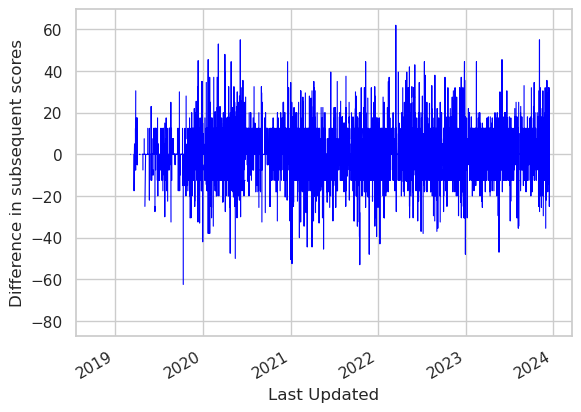

In [46]:
domain_updates_sorted\
    .groupby(domain_updates_sorted["Last Updated"]).Score_diff\
    .mean()\
    .plot(color="blue", 
          linewidth=0.8)
plt.ylabel("Difference in subsequent scores")
plt.xlabel("Time (years)")

plt.savefig(join(figures_path, "fa2-score_updates.png"), 
            dpi=300)
plt.show()

/tmp/ipykernel_1466227/4276977480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df15_UUID["last_updated_month"] = pd.to_datetime(df15_UUID["Last Updated"])\


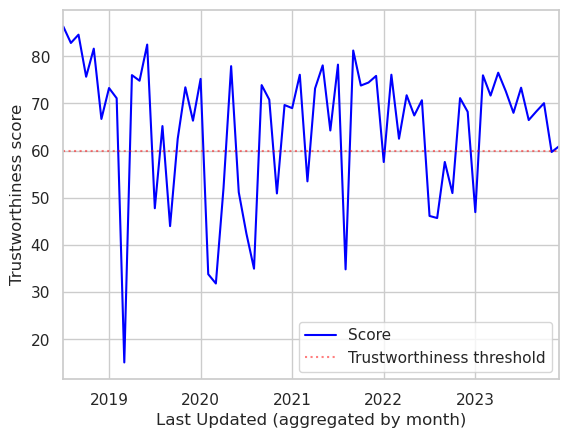

In [47]:
df15_UUID["last_updated_month"] = pd.to_datetime(df15_UUID["Last Updated"])\
                                .dt.to_period("M")
df15_UUID.groupby(df15_UUID.last_updated_month).Score\
    .mean()\
    .plot(color="blue", 
          label="Score")
plt.xlabel("Time")
plt.ylabel("Trustworthiness")
plt.axhline(y=60, color="red", 
            linestyle="dotted", 
            alpha=0.5, 
            label="Trustworthiness threshold")
plt.savefig(join(figures_path, "average_score_per_update.png"), dpi=300)
plt.legend()
plt.show()

In [48]:
domain_updates_sorted.sort_values("Score_diff", ascending=True)\
                                [["Domain", "Score_diff", "Last Updated"]]\
                        .head(5)

,Domain,Score_diff,Last Updated
7183,conservativedailynews.com,-80.0,2020-11-23 21:39:32.187
38231,thefederalist.com,-62.5,2019-10-10 17:21:38.137
38868,theragingpatriot.com,-53.0,2021-10-15 12:19:44.207
38758,theohiostar.com,-52.5,2021-01-05 22:53:34.221
30053,pluralist.com,-50.5,2020-12-31 18:12:44.411


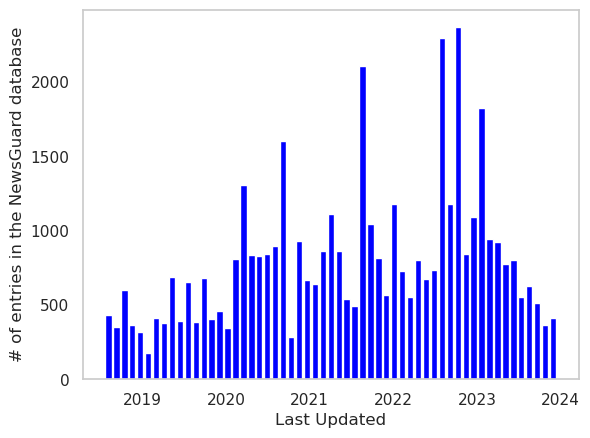

In [49]:
df15_UUID["Last Updated"].hist(bins=df15_UUID["file_date"].nunique(), 
                               color="blue", 
                               rwidth=0.8,
                               grid=False)
plt.xlabel("Last Updated")
plt.ylabel("# of entries in the NewsGuard database")
#plt.savefig(join(figures_path, "last_updated_distribution.png"), dpi=300)
plt.show()

## Composition of trustworthiness score

In [50]:
criteria_columns_all = df15[
       ["Does not repeatedly publish false content",
       "Gathers and presents information responsibly",
       "Regularly corrects or clarifies errors",
       "Handles the difference between news and opinion responsibly",
       "Avoids deceptive headlines",
       "Website discloses ownership and financing",
       "Clearly labels advertising",
       "Reveals who's in charge, including any possible conflicts of interest",
       "The site provides names of content creators, along with either contact or biographical information",
       "Does not repeatedly publish false or egregiously misleading content",
       "Has effective practices for correcting errors"]
       ]

In [51]:
counts_data = []

for column in criteria_columns_all:
    column_counts = df15\
                        .groupby("file_date")[column]\
                        .count()\
                        .reset_index()
    column_counts = column_counts\
                        .rename(columns={column: "count"})
    column_counts["criteria"] = column
    counts_data.append(column_counts)

counts_table = pd.concat(counts_data, ignore_index=True)

counts_table = counts_table[["file_date", "criteria", "count"]]

In [52]:
first_ratings = counts_table[counts_table["count"] > 0]


first_ratings = first_ratings\
    .groupby("criteria")\
        .agg(
            min_date=("file_date", "min"),
            max_date=("file_date", "max"))\
    .reset_index()

first_ratings

,criteria,min_date,max_date
0,Avoids deceptive headlines,2019-03-15 01:00:00,2023-12-15 01:00:00
1,Clearly labels advertising,2019-03-15 01:00:00,2023-12-15 01:00:00
2,Does not repeatedly publish false content,2019-03-15 01:00:00,2023-11-15 01:00:00
3,Does not repeatedly publish false or egregious...,2023-12-15 01:00:00,2023-12-15 01:00:00
4,Gathers and presents information responsibly,2019-03-15 01:00:00,2023-12-15 01:00:00
5,Handles the difference between news and opinio...,2019-03-15 01:00:00,2023-12-15 01:00:00
6,Has effective practices for correcting errors,2023-12-15 01:00:00,2023-12-15 01:00:00
7,Regularly corrects or clarifies errors,2019-03-15 01:00:00,2023-11-15 01:00:00
8,"Reveals who's in charge, including any possibl...",2019-03-15 01:00:00,2023-12-15 01:00:00
9,"The site provides names of content creators, a...",2019-03-15 01:00:00,2023-12-15 01:00:00


In [53]:
criteria_columns_recent = most_recent[
       ["Does not repeatedly publish false or egregiously misleading content",
       "Gathers and presents information responsibly",
       "Handles the difference between news and opinion responsibly",
       "Avoids deceptive headlines",
       "Website discloses ownership and financing",
       "Clearly labels advertising",
       "Reveals who's in charge, including any possible conflicts of interest",
       "The site provides names of content creators, along with either contact or biographical information",
       "Has effective practices for correcting errors"]
       ]

In [54]:
for df in [df15, df15_UUID, most_recent, criteria_columns_recent, criteria_columns_all]:
    df = df.rename(columns={
    "Reveals who's in charge, including any possible conflicts of interest": 
    "Reveals who's in charge,\n including any possible conflicts of interest", 
    "The site provides names of content creators, along with either contact or biographical information":
    "The site provides names of content creators,\n along with either contact or biographical information"}, 
    inplace=True)

/tmp/ipykernel_1466227/1430295996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df = df.rename(columns={
/tmp/ipykernel_1466227/1430295996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df = df.rename(columns={
/tmp/ipykernel_1466227/1430295996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df = df.rename(columns={
/tmp/ipykernel_1466227/1430295996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

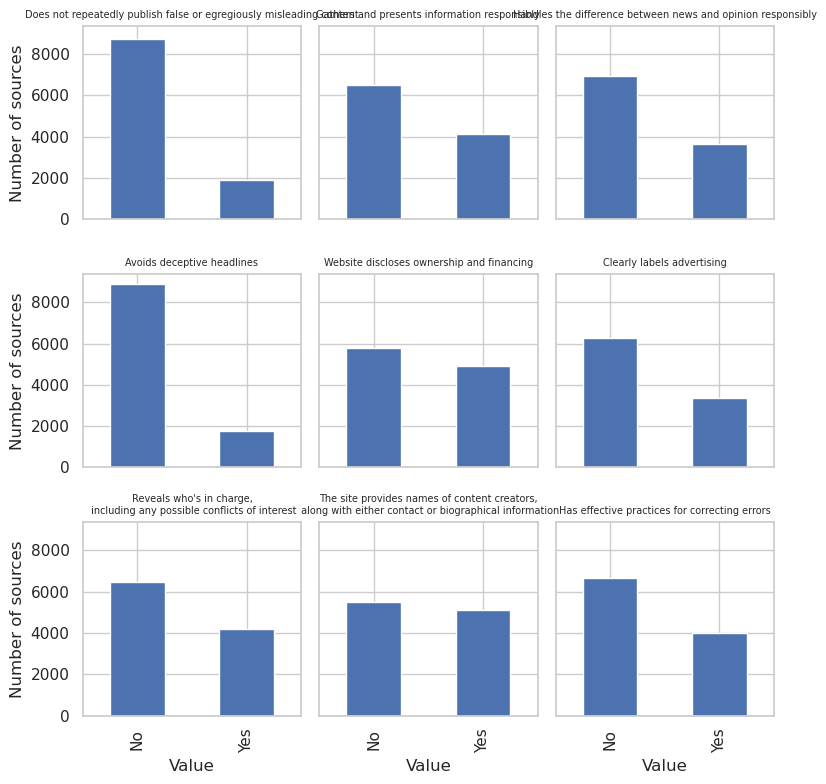

In [55]:
def plot_yesno(columns):
    fig, axs = plt.subplots(nrows=3, 
                            ncols=3, 
                            sharex=True,
                            sharey=True,
                            figsize=(8, 8))

    for i, col in enumerate(columns):
        row = i // 3 
        col_in_row = i % 3  
        most_recent[col]\
            .value_counts()\
            .plot(kind="bar",
                  ax=axs[row, col_in_row])
        axs[row, col_in_row].set_xlabel("Value")
        axs[row, col_in_row].set_ylabel("Number of sources")
        axs[row, col_in_row].set_title(f'{col}', fontsize=7)

    plt.tight_layout()
    plt.show()

plot_yesno(criteria_columns_recent)

In [56]:
most_recent_critera = pd.melt(criteria_columns_recent, 
                      value_vars=criteria_columns_recent, 
                      var_name="Criteria", 
                      value_name="Label")
criteria_counts = most_recent_critera\
                    .groupby(["Criteria", "Label"])\
                    .size()\
                    .unstack(fill_value=0)\
                    .reset_index()

criteria_counts["Total"] = criteria_counts["Yes"] + criteria_counts["No"]
criteria_counts["Yes%"] = criteria_counts["Yes"] / criteria_counts["Total"] * 100
criteria_counts["No%"] = criteria_counts["No"] / criteria_counts["Total"] * 100

criteria_counts.sort_values(by="Yes", ascending=False)

Label,Criteria,No,Yes,Total,Yes%,No%
0,Avoids deceptive headlines,1742,8903,10645,83.635510,16.364490
2,Does not repeatedly publish false or egregious...,1922,8736,10658,81.966598,18.033402
4,Handles the difference between news and opinio...,3628,6967,10595,65.757433,34.242567
3,Gathers and presents information responsibly,4149,6509,10658,61.071496,38.928504
6,"Reveals who's in charge,\n including any possi...",4190,6465,10655,60.675739,39.324261
1,Clearly labels advertising,3363,6253,9616,65.027038,34.972962
7,"The site provides names of content creators,\n...",5508,5114,10622,48.145359,51.854641
8,Website discloses ownership and financing,5767,4891,10658,45.890411,54.109589
5,Has effective practices for correcting errors,6671,3986,10657,37.402646,62.597354


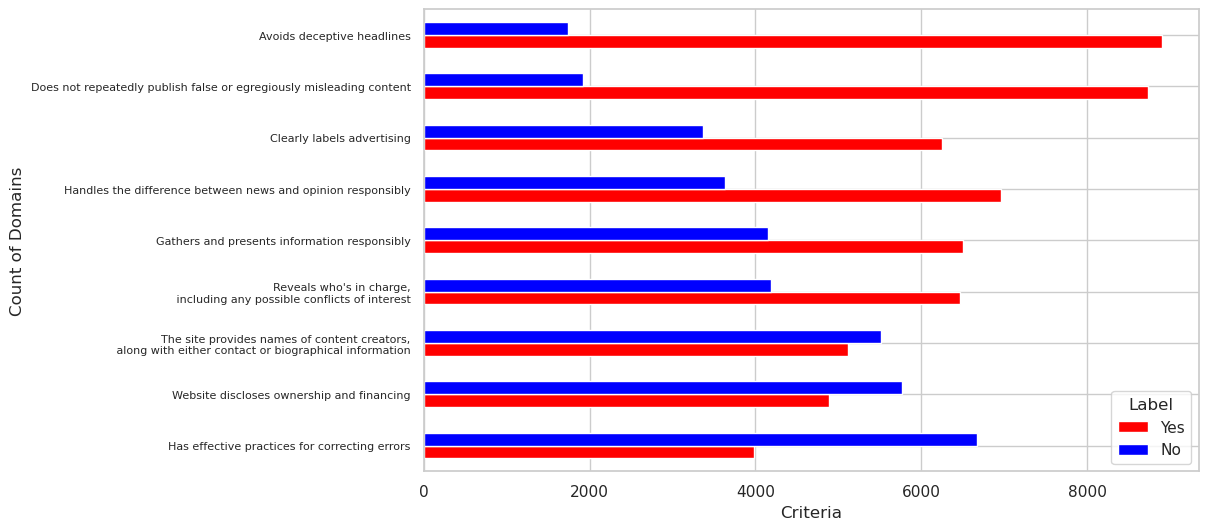

In [57]:
criteria_counts\
    .sort_values("No", ascending=False)\
    .plot(x="Criteria", 
          y=["Yes", "No"],
          kind="barh", 
          stacked=False,
          color=["red", "blue"], 
          figsize=(10, 6))
plt.xlabel("Criteria")
plt.ylabel("Counts")
plt.yticks(fontsize=8)
plt.legend(title="Label", 
           loc="lower right")

plt.savefig(join(figures_path, "criteria_counts.png"),
            dpi=300)
plt.show()

In [58]:
criteria_columns_recent = \
    criteria_columns_recent\
        .replace({"Yes": 1, "No": 0})\
        .fillna(0)

cooccurrence = \
    criteria_columns_recent\
        .T\
        .dot(criteria_columns_recent)
cooccurrence

,Does not repeatedly publish false or egregiously misleading content,Gathers and presents information responsibly,Handles the difference between news and opinion responsibly,Avoids deceptive headlines,Website discloses ownership and financing,Clearly labels advertising,"Reveals who's in charge,\n including any possible conflicts of interest","The site provides names of content creators,\n along with either contact or biographical information",Has effective practices for correcting errors
Does not repeatedly publish false or egregiously misleading content,8736.0,6509.0,6504.0,8574.0,4634.0,5552.0,5539.0,4780.0,3984.0
Gathers and presents information responsibly,6509.0,6509.0,6033.0,6496.0,4365.0,4908.0,5188.0,4454.0,3797.0
Handles the difference between news and opinion responsibly,6504.0,6033.0,6967.0,6651.0,4365.0,5151.0,5195.0,4473.0,3661.0
Avoids deceptive headlines,8574.0,6496.0,6651.0,8903.0,4651.0,5634.0,5645.0,4884.0,3970.0
Website discloses ownership and financing,4634.0,4365.0,4365.0,4651.0,4891.0,3842.0,4034.0,3272.0,2883.0
Clearly labels advertising,5552.0,4908.0,5151.0,5634.0,3842.0,6253.0,4350.0,3815.0,3363.0
"Reveals who's in charge,\n including any possible conflicts of interest",5539.0,5188.0,5195.0,5645.0,4034.0,4350.0,6465.0,4202.0,3123.0
"The site provides names of content creators,\n along with either contact or biographical information",4780.0,4454.0,4473.0,4884.0,3272.0,3815.0,4202.0,5114.0,3168.0
Has effective practices for correcting errors,3984.0,3797.0,3661.0,3970.0,2883.0,3363.0,3123.0,3168.0,3986.0


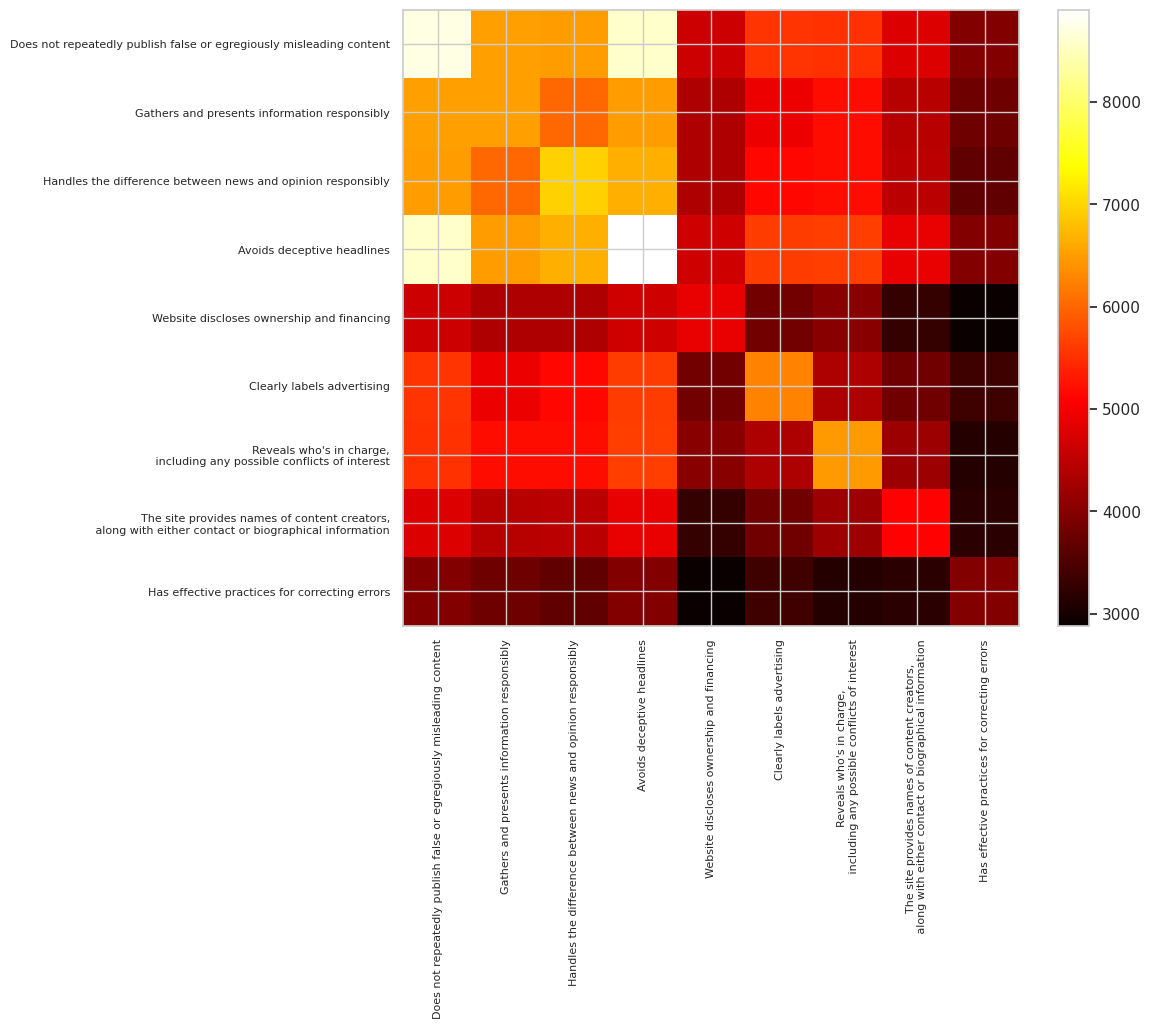

In [59]:
plt.figure(figsize=(10, 8))
plt.imshow(cooccurrence, 
           cmap="hot", 
           interpolation="nearest")

plt.xticks(range(len(cooccurrence)), 
           cooccurrence.columns, 
           rotation=90, 
           fontsize=8)
plt.yticks(range(len(cooccurrence)), 
           cooccurrence.index, 
           fontsize=8)
plt.colorbar()
#for i in range(len(cooccurrence)):
#    for j in range(len(cooccurrence)):
#        plt.text(j, i, cooccurrence.iloc[i, j], 
#        ha="center", va="center", color="grey")
plt.show()

In [60]:
#correlation matrix
corr = criteria_columns_recent.corr()
corr.style.background_gradient(cmap="coolwarm")

,Does not repeatedly publish false or egregiously misleading content,Gathers and presents information responsibly,Handles the difference between news and opinion responsibly,Avoids deceptive headlines,Website discloses ownership and financing,Clearly labels advertising,"Reveals who's in charge, including any possible conflicts of interest","The site provides names of content creators, along with either contact or biographical information",Has effective practices for correcting errors
Does not repeatedly publish false or egregiously misleading content,1.000000,0.632260,0.487145,0.874594,0.364724,0.306745,0.232961,0.351954,0.399764
Gathers and presents information responsibly,0.632260,1.000000,0.744368,0.600000,0.559896,0.471331,0.530666,0.543196,0.562926
Handles the difference between news and opinion responsibly,0.487145,0.744368,1.000000,0.518585,0.496352,0.475274,0.445746,0.483357,0.458941
Avoids deceptive headlines,0.874594,0.600000,0.518585,1.000000,0.349543,0.309731,0.243236,0.372876,0.376572
Website discloses ownership and financing,0.364724,0.559896,0.496352,0.349543,1.000000,0.408651,0.446767,0.380439,0.433207
Clearly labels advertising,0.306745,0.471331,0.475274,0.309731,0.408651,1.000000,0.279080,0.353102,0.431678
"Reveals who's in charge, including any possible conflicts of interest",0.232961,0.530666,0.445746,0.243236,0.446767,0.279080,1.000000,0.459266,0.316063
"The site provides names of content creators, along with either contact or biographical information",0.351954,0.543196,0.483357,0.372876,0.380439,0.353102,0.459266,1.000000,0.507955
Has effective practices for correcting errors,0.399764,0.562926,0.458941,0.376572,0.433207,0.431678,0.316063,0.507955,1.000000


In [61]:
#save as latex table
corr.to_latex(join(tables_path, "criteria_correlation_recent.tex"))

/tmp/ipykernel_1466227/1938248488.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  corr.to_latex(join(tables_path, "criteria_correlation_recent.tex"))


In [62]:
#exploratory factor analysis of criteria
chi_square_value,p_value=calculate_bartlett_sphericity(criteria_columns_recent)
chi_square_value, p_value # there is a significant correlation among the variables

(55729.47940051169, 0.0)

In [63]:
#squared partial correlations
kmo_all,kmo_model=calculate_kmo(criteria_columns_recent)
kmo_model #adequate sample size (larger than 0.5)

/home/jluehring/miniconda3/envs/twarcing/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.8480992407892035

In [64]:
fa = FactorAnalyzer(rotation=None)
fa.fit(criteria_columns_recent, 25)
ev, v = fa.get_eigenvalues()
ev #2 factors have eigenvalues > 1

array([4.66026921, 1.15357739, 0.76005167, 0.66882936, 0.55043085,
       0.44999158, 0.4213669 , 0.22013828, 0.11534476])

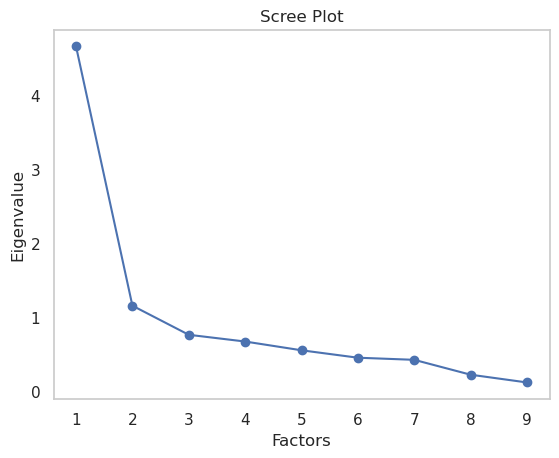

In [65]:
#screeplot
plt.scatter(range(1,criteria_columns_recent.shape[1]+1),ev)
plt.plot(range(1,criteria_columns_recent.shape[1]+1),ev)
plt.title("Scree Plot")
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()

In [66]:
fa = FactorAnalyzer(n_factors=2, 
                    rotation="oblimin")
fa.fit(criteria_columns_recent)
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, 
                           index=criteria_columns_recent.columns)
loadings_df

,0,1
Does not repeatedly publish false or egregiously misleading content,-0.007203,0.971009
Gathers and presents information responsibly,0.764231,0.190377
Handles the difference between news and opinion responsibly,0.712764,0.103768
Avoids deceptive headlines,0.051275,0.872558
Website discloses ownership and financing,0.685767,-0.045996
Clearly labels advertising,0.585557,-0.024349
"Reveals who's in charge,\n including any possible conflicts of interest",0.711580,-0.184192
"The site provides names of content creators,\n along with either contact or biographical information",0.685368,-0.043339
Has effective practices for correcting errors,0.635677,0.024669


In [67]:
#variance explained
fa.get_factor_variance()[0]

array([3.28807742, 1.79034981])

In [68]:
#in percentage
fa.get_factor_variance()[2]*100

array([36.5341936 , 56.42696932])

### Trustworthiness

In [69]:
#regression: which criteria are most important for the overall score?
for criteria in criteria_columns_recent.columns:
    most_recent = most_recent.replace({criteria: {"Yes": 1, "No": 0}})
    most_recent = most_recent.dropna(subset=[criteria])
    most_recent = most_recent.dropna(subset=["Score"])
    X = most_recent[criteria]
    y = most_recent["Score"]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    print(f'Criteria: {criteria}')
    print(f'Coefficient: {model.params[criteria]}')
    print(f'P-value: {model.pvalues[criteria]}')

Criteria: Does not repeatedly publish false or egregiously misleading content
Coefficient: 61.93807002159397
P-value: 0.0
Criteria: Gathers and presents information responsibly
Coefficient: 59.684019338631884
P-value: 0.0
Criteria: Handles the difference between news and opinion responsibly
Coefficient: 53.22896371285186
P-value: 0.0
Criteria: Avoids deceptive headlines
Coefficient: 61.914984198684394
P-value: 0.0
Criteria: Website discloses ownership and financing
Coefficient: 41.178929750075
P-value: 0.0


Criteria: Clearly labels advertising
Coefficient: 36.84793542678428
P-value: 0.0
Criteria: Reveals who's in charge,
 including any possible conflicts of interest
Coefficient: 31.527043420954744
P-value: 0.0
Criteria: The site provides names of content creators,
 along with either contact or biographical information
Coefficient: 40.235255413565525
P-value: 0.0
Criteria: Has effective practices for correcting errors
Coefficient: 45.45482084895889
P-value: 0.0


In [70]:
#multiple combinations of criteria
combinations = criteria_columns_recent\
                .groupby(criteria_columns_recent.columns\
                         .tolist())\
                .size()\
                .reset_index(name="Counts")

combinations["Percentage"] = \
    combinations["Counts"]/(most_recent["Score"].count())*100

combinations\
    .sort_values("Counts", ascending=False)\
    .head(10)

,Does not repeatedly publish false or egregiously misleading content,Gathers and presents information responsibly,Handles the difference between news and opinion responsibly,Avoids deceptive headlines,Website discloses ownership and financing,Clearly labels advertising,"Reveals who's in charge,\n including any possible conflicts of interest","The site provides names of content creators,\n along with either contact or biographical information",Has effective practices for correcting errors,Counts,Percentage
204,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1500,15.693660
73,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1290,13.496547
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,974,10.190416
203,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,505,5.283532
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,503,5.262607
188,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,476,4.980121
201,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,419,4.383762
179,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,387,4.048964
202,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,345,3.609542
200,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,333,3.483992


In [71]:
#criteria changes over time 
df15 = df15\
        .replace({"Yes": 1, 
                  "No": 0})

criteria_avg = df15\
    .groupby("file_month")[criteria_columns_all.columns]\
    .mean()

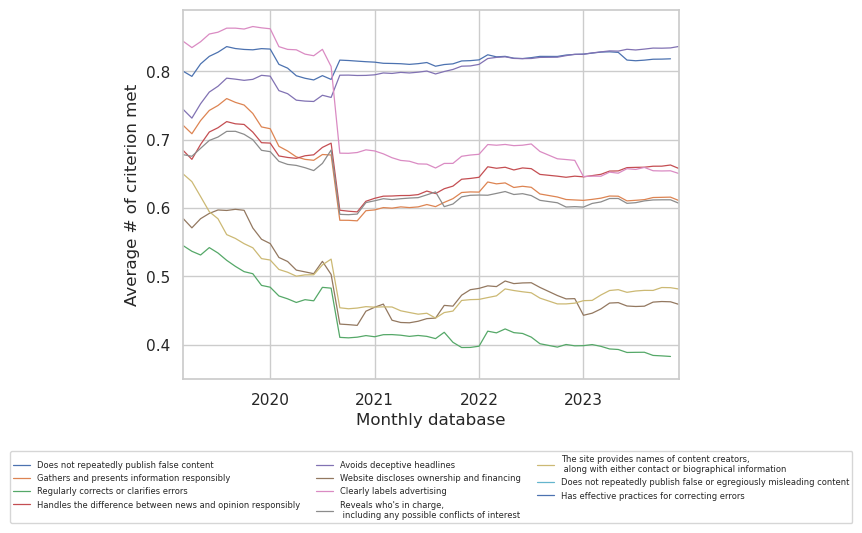

In [72]:
for col in criteria_columns_all:
    criteria_avg[col]\
        .plot(label=col, linewidth=0.9)
    
plt.xlabel("Monthly database")
plt.ylabel("Average # of criterion met")
plt.legend(loc="lower center", 
           bbox_to_anchor=(0.5, -0.4), 
           ncol=3, 
           fontsize=6)
plt.show()

### Updates

In [73]:
df15_UUID = \
    df15_UUID\
        .replace({"Yes": 1, 
                  "No": 0})

In [74]:
#collapse the two columns
df15_UUID["Does not repeatedly publish false or egregiously misleading content"] = \
    df15_UUID[["Does not repeatedly publish false content", 
                "Does not repeatedly publish false or egregiously misleading content"]]\
    .max(axis=1)

df15_UUID["Has effective practices for correcting errors"] = \
    df15_UUID[["Regularly corrects or clarifies errors", 
                "Has effective practices for correcting errors"]]\
    .max(axis=1)

In [75]:
#changes over time per criterion per domain
criteria_dated = df15_UUID\
                    .groupby("Domain")\
                    .apply(lambda x: x \
                        .sort_values("Last Updated"))\
                    .reset_index(drop=True)

criteria_dated.head(3)

,UUID,Domain,Parent Domain,Rating,Score,Last Updated,Country,Language,Does not repeatedly publish false content,Gathers and presents information responsibly,...,OTHER,Contact Mail Form URL.1,Communities Served,BrandGuard Segments,False Narratives,Does not repeatedly publish false or egregiously misleading content,Has effective practices for correcting errors,file_year,file_month,last_updated_month
0,b9704871-32df-4721-881c-2dc6d03d8905,1000logos.net,NaN,FL,NaN,2023-09-27 04:25:20.721,US,en,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2023-10,2023-09
1,07be0795-9c5e-43ad-932b-e7e0154d5828,100fedup.com,100percentfedup.com,N,7.5,2018-09-08 22:26:33.205,US,en,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2019,2019-03,2018-09
2,a7cfbf89-68cf-4a16-9b92-96cbda6cdad5,100fedup.com,100percentfedup.com,N,7.5,2019-10-04 23:22:52.632,US,en,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2019,2019-10,2019-10


In [76]:
criteria_diffs = pd.DataFrame()
for criterion in criteria_columns_recent.columns:
    criteria_dated[criterion] = \
        criteria_dated[criterion]\
            .replace({"Yes": 1, "No": 0})
    criteria_dated[f'Diff_{criterion}'] = \
        criteria_dated\
            .groupby("Domain")[criterion]\
            .diff()
    criteria_diffs[f'Diff_{criterion}'] = \
        criteria_dated[f'Diff_{criterion}']
criteria_diffs.tail(10)

,Diff_Does not repeatedly publish false or egregiously misleading content,Diff_Gathers and presents information responsibly,Diff_Handles the difference between news and opinion responsibly,Diff_Avoids deceptive headlines,Diff_Website discloses ownership and financing,Diff_Clearly labels advertising,"Diff_Reveals who's in charge,\n including any possible conflicts of interest","Diff_The site provides names of content creators,\n along with either contact or biographical information",Diff_Has effective practices for correcting errors
45284,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
45285,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
45286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
criteria_change = \
    criteria_diffs\
        .mean()\
        .reset_index()\
        .rename(columns={"index": "Criteria", 
                         0: "Avg Change"})

total_change = criteria_diffs\
                    .astype(bool)\
                    .sum()

negative_changes = (criteria_diffs < 0).sum()
positive_changes = (criteria_diffs > 0).sum()

negative_changes_percentage = \
    (negative_changes / criteria_dated.Domain.nunique() * 100)\
    .round(2)


positive_changes_percentage = \
    (positive_changes / criteria_dated.Domain.nunique() * 100)\
    .round(2)

criteria_changes = pd.DataFrame({
    "Criteria": criteria_change["Criteria"],
    "Total Change": total_change.values,
    "Avg. Change": criteria_change["Avg Change"],
    "Negative Changes": -negative_changes_percentage.values,
    "Positive Changes": positive_changes_percentage.values}
    )

criteria_changes["Criteria"] = \
    criteria_changes["Criteria"]\
        .str.replace("Diff_", "")

criteria_changes.sort_values(by="Total Change")

,Criteria,Total Change,Avg. Change,Negative Changes,Positive Changes
0,Does not repeatedly publish false or egregious...,10864,0.000722,-0.81,1.05
3,Avoids deceptive headlines,10970,0.002861,-0.87,1.84
1,Gathers and presents information responsibly,10986,-0.001242,-1.73,1.31
2,Handles the difference between news and opinio...,11424,0.004996,-1.87,3.54
6,"Reveals who's in charge,\n including any possi...",11775,-0.001444,-5.59,5.10
7,"The site provides names of content creators,\n...",11971,0.003814,-5.63,6.91
8,Has effective practices for correcting errors,12292,0.004564,-7.08,8.62
4,Website discloses ownership and financing,12877,-0.007598,-11.96,9.40
5,Clearly labels advertising,14783,-0.019126,-9.42,3.51


In [78]:
criteria_dated\
    [criteria_dated["Diff_Website discloses ownership and financing"] == -1]\
    ["Domain"].unique()

array(['1011now.com', '12thmanrising.com', '13abc.com', ...,
       'yournewswire.com', 'zeit.de', 'zonazealots.com'], dtype=object)

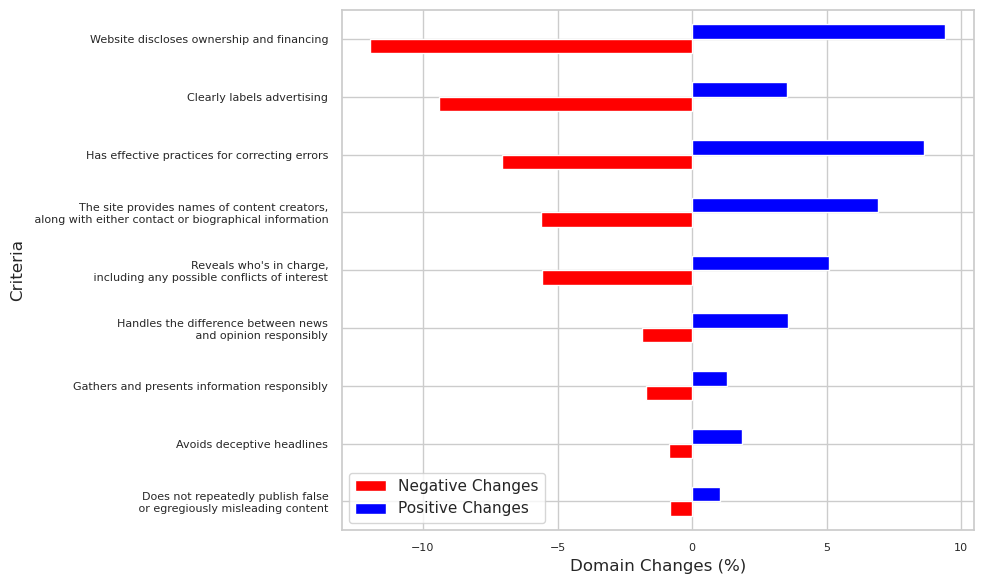

In [79]:
#bar chart with change percentages
#change the label of one of the criteria
criteria_changes["Criteria"] = \
    criteria_changes["Criteria"]\
        .replace({"Does not repeatedly publish false or egregiously misleading content": 
                   "Does not repeatedly publish false\n or egregiously misleading content",
                   "Handles the difference between news and opinion responsibly":
                   "Handles the difference between news\n and opinion responsibly"})

criteria_changes\
    .sort_values(by="Negative Changes", ascending=False)\
    .plot(x="Criteria", 
          y=["Negative Changes", "Positive Changes"],
          kind="barh", 
          stacked=False,
          color=["red", "blue"], 
          figsize=(10, 6))

plt.xlabel("Domain Changes (%)")
plt.ylabel("Criteria")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.tight_layout()
plt.savefig(join(figures_path, "f4-criteria_changes.png"), 
            dpi=300)
plt.show()

## Countries

In [80]:
lang = df15\
    .groupby("Language")\
    .agg(n=("Domain", "nunique"))\
    .reset_index()

lang\
    .columns = ["Language", "n"]

lang["%"] = \
    (lang["n"] / lang["n"].sum()) * 100

lang

,Language,n,%
0,de,402,3.373898
1,en,10520,88.292069
2,es,1,0.008393
3,fr,466,3.911037
4,it,526,4.414603


In [81]:
countries_lang = df15\
    .groupby(["Country", "Language"])\
    .agg(n=("Domain", "nunique"))\
    .reset_index()

countries_lang\
    .columns = ["Country", "Language", "n"]

countries_lang["\%"] = \
    (countries_lang["n"] / df15["Domain"]\
        .nunique() * 100)\
        .round(2)

countries_lang

,Country,Language,n,\%
0,ALL,en,1451,13.79
1,AT,de,40,0.38
2,AU,en,140,1.33
3,CA,en,421,4.00
4,CA,fr,45,0.43
5,DE,de,375,3.56
6,FR,fr,431,4.10
7,GB,en,621,5.90
8,IT,it,526,5.00
9,NZ,en,21,0.20


In [82]:
#save table as latex >turn into function for later tables?
countries_lang_latex = countries_lang \
    .sort_values("n", ascending=False) \
    .to_latex(
        index=False, 
        escape=False,
        caption="\\textbf{Country Descriptives.}",
        label="table:table1", 
        position='H',
        column_format=' X c c c c',
        longtable=False, 
        header=True, 
        na_rep='---', 
        bold_rows=True)

countries_lang_latex = \
    countries_lang_latex\
    .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")
countries_lang_latex = \
    countries_lang_latex\
    .replace("\\end{tabular}", "\\end{tabularx}")

countries_lang_latex = \
    countries_lang_latex\
    .replace("\\bottomrule", "\\bottomrule\n\\textit{Note.} We counted unique domains across all versions of the database.")

with open(join(tables_path, 
               "countries_language.tex"), 'w') as f:
    f.write(countries_lang_latex)

/tmp/ipykernel_1466227/4049951621.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  countries_lang_latex = countries_lang \


In [83]:
country_means = \
    df15\
        .groupby(["Country", "file_date"])\
        .agg({"Score": ["mean", "std"]})\
        .reset_index()

country_means\
    .columns = ["Country", "file_date", "Score_mean", "Score_std"]

country_means = \
    country_means\
        .groupby("Country")\
        .agg({"Score_mean": "mean", "Score_std": "mean"})\
        .reset_index()\
        .round(2)

country_means["Trustworthiness (SD)"] = \
    country_means\
        .apply(lambda row: f'{row["Score_mean"]} ({row["Score_std"]})', 
               axis=1)
country_means = \
    country_means\
        .drop(["Score_mean", "Score_std"], 
              axis=1)

#add n
country_means["n"] = \
    df15\
        .groupby("Country")\
        .agg({"Domain": "nunique"})\
        .reset_index()["Domain"]

#percentage
country_means["%"] = \
    (country_means["n"] / df15["Domain"].nunique() * 100)\
        .round(2)

country_means["n (\%)"] = \
    country_means\
        .apply(lambda row: f'{row["n"]} ({row["%"]})', 
               axis=1)

country_means = \
    country_means\
        .drop("%", 
              axis=1)

#reorder columns
country_means = \
    country_means[["Country", "n (\%)", 
                   "Trustworthiness (SD)"]]

#order
country_means = \
    country_means\
        .sort_values("n (\%)", ascending=False)\
        .reset_index(drop=True)

country_means

,Country,n (\%),Trustworthiness (SD)
0,US,7996 (76.0),62.34 (35.12)
1,GB,621 (5.9),79.64 (21.68)
2,IT,526 (5.0),73.08 (24.33)
3,CA,466 (4.43),86.48 (16.58)
4,FR,431 (4.1),66.47 (29.24)
5,AT,40 (0.38),71.96 (30.74)
6,DE,375 (3.56),78.09 (30.1)
7,NZ,21 (0.2),80.85 (26.53)
8,ALL,1451 (13.79),72.44 (27.9)
9,AU,140 (1.33),71.41 (28.56)


In [84]:
language_score = df15\
    .groupby(["Language", "file_date"])\
    .agg({"Score": "mean"})\
    .reset_index()

language_score\
    .groupby("Language").Score\
    .mean()\
    .sort_values(ascending=False)

Language
es    82.500000
de    77.988935
it    73.082327
fr    66.892975
en    65.238491
Name: Score, dtype: float64

In [85]:
country_score = df15.groupby(["Country","file_date"]).agg(
    {"Score": "mean"}).reset_index()

country_score.groupby("Country").Score\
                .mean()\
                .sort_values(ascending=False)

Country
CA     86.477423
NZ     80.851896
GB     79.643453
DE     78.093508
IT     73.082327
ALL    72.438902
AT     71.960946
AU     71.405926
FR     66.465063
US     62.339282
Name: Score, dtype: float64

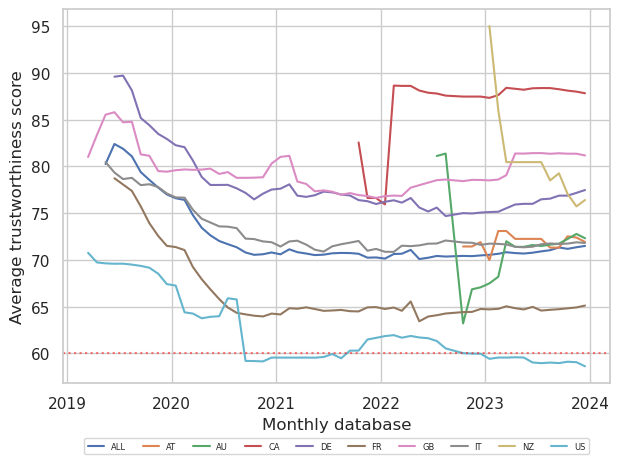

In [86]:
for country in country_score["Country"].unique():
    country_df = country_score[country_score["Country"] == country]
    plt.plot(country_df["file_date"], country_df["Score"], 
             label=country)
    
plt.axhline(y=60, 
            color="red", 
            linestyle="dotted", 
            alpha=0.5)

plt.xlabel("Monthly database")
plt.ylabel("Average trustworthiness score")
plt.legend(loc="lower center", 
           bbox_to_anchor=(0.5, -0.2), 
           ncol=len(country_score), 
           fontsize=6)
plt.tight_layout()

plt.savefig(join(figures_path,"f5-scores_over_time_per_country.png"), 
            dpi=300)

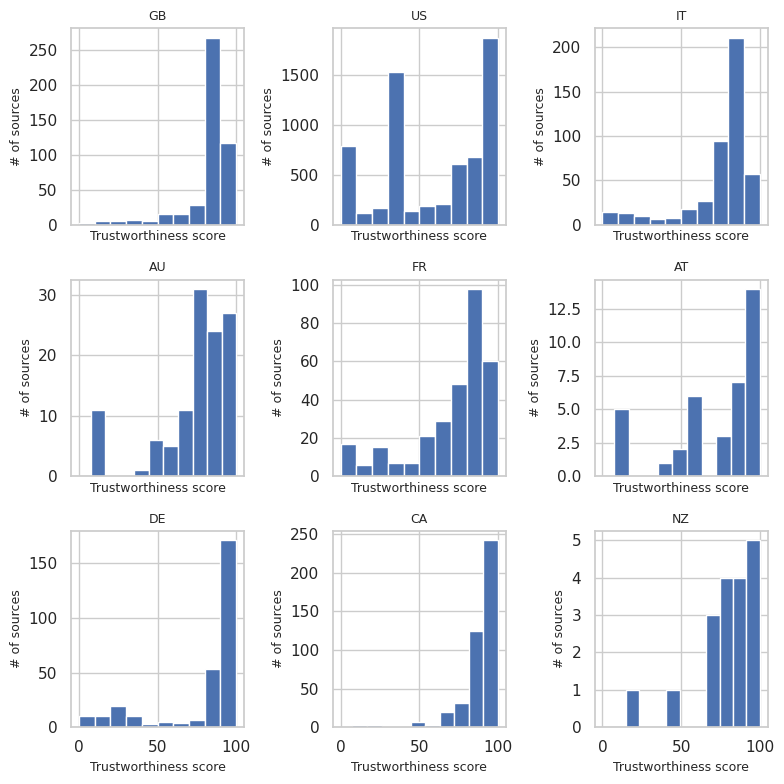

In [87]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=False, sharex=True)
country_df = most_recent[most_recent["Country"] != "ALL"]

for i, country in enumerate(country_df["Country"].unique()):
    row = i // 3 
    col_in_row = i % 3  
    df = country_df[country_df["Country"] == country]
    df["Score"].hist(ax=axs[row, col_in_row])
    axs[row, col_in_row].set_xlabel("Trustworthiness score", fontsize=9)
    axs[row, col_in_row].set_ylabel("# of sources", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)

plt.tight_layout()

plt.savefig(join(figures_path,"scores_per_country_recent.png"), dpi=300)
plt.show()

In [88]:
#do the same with the number of domains over time
country_domains = df15.groupby(["Country","file_date"]).agg(
    {"Domain": "nunique"}).reset_index()

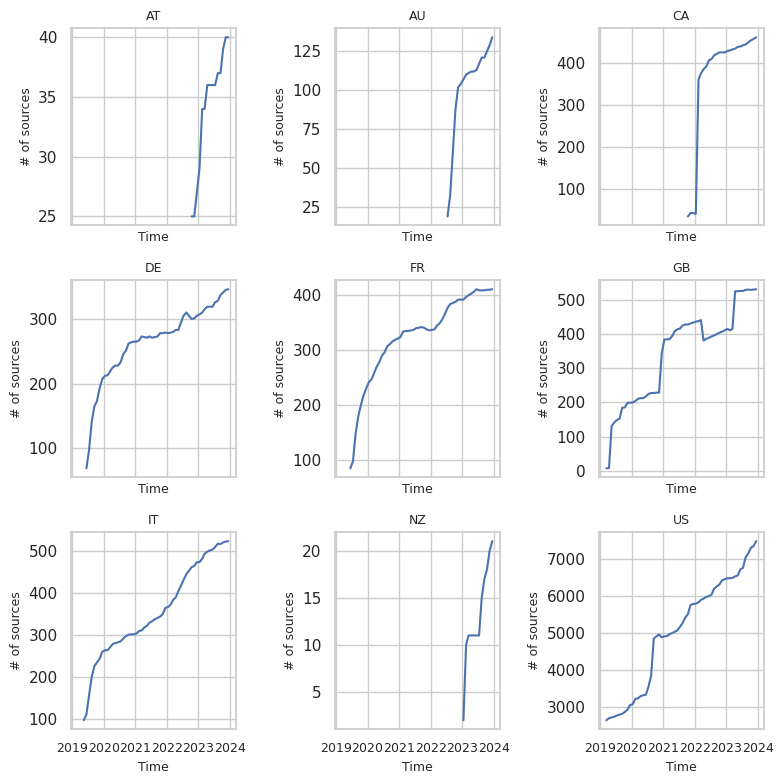

In [89]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=False, sharex=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

filtered_countries = country_domains[country_domains["Country"] != "ALL"]["Country"].unique()

for i, country in enumerate(filtered_countries):
    row = i // 3 
    col_in_row = i % 3  
    df = country_domains[country_domains["Country"] == country]  
    axs[row, col_in_row].plot(df["file_date"], df["Domain"], label=country)
    axs[row, col_in_row].set_xlabel("Time", fontsize=9)
    axs[row, col_in_row].set_ylabel("# of sources", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)
    axs[row, col_in_row].tick_params(axis="x", labelsize=9)

plt.tight_layout()
plt.savefig(join(figures_path,"n_country_over_time.png"), dpi=300)
plt.show()

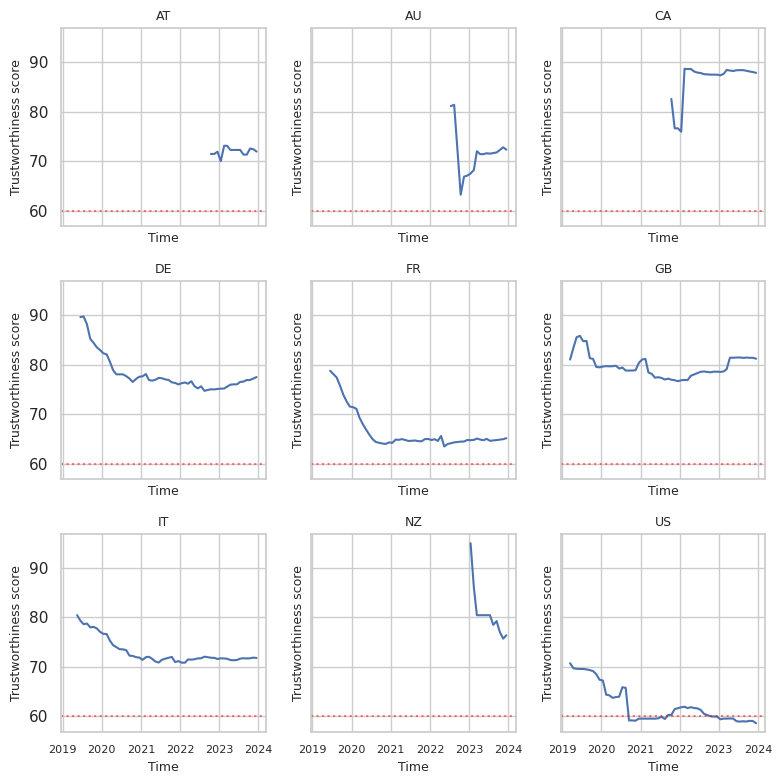

In [90]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, country in enumerate(filtered_countries):
    row = i // 3 
    col_in_row = i % 3  
    df = country_score[country_score["Country"] == country]  
    axs[row, col_in_row].plot(df["file_date"], df["Score"], 
                              label=country)
    axs[row, col_in_row].set_xlabel("Time", fontsize=9)
    axs[row, col_in_row].set_ylabel("Trustworthiness score", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)
    axs[row, col_in_row].tick_params(axis="x", labelsize=8)
    axs[row, col_in_row].axhline(y=60, color="red", linestyle="dotted", 
                                 alpha=0.5, label="Trustworthiness threshold")

plt.tight_layout()
plt.savefig(join(figures_path,"scores_country_over_time.png"), dpi=300)
plt.show()

In [91]:
country_updates_sorted = df15_UUID\
                            [["Country", "Domain", "Last Updated", "Score"]]\
                            .sort_values(
                                by=["Country", "Domain", "Last Updated"])\
                            .reset_index(drop=True)

In [92]:
country_updates_sorted["Time_Diff"] = country_updates_sorted\
                            .groupby(["Country", "Domain"])\
                            ["Last Updated"]\
                            .diff()

country_updates_sorted["Score_Diff"] = country_updates_sorted\
                            .groupby(["Country", "Domain"])\
                            ["Score"]\
                            .diff()
country_updates_sorted.head(3)

,Country,Domain,Last Updated,Score,Time_Diff,Score_Diff
0,ALL,100giornidaleoni.it,2022-05-23 10:23:51.210,30.0,NaT,NaN
1,ALL,100giornidaleoni.it,2023-05-24 09:25:20.659,30.0,365 days 23:01:29.449000,0.0
2,ALL,2020news.de,2021-04-20 12:24:13.398,20.0,NaT,NaN


In [93]:
time_diff_per_domain = country_updates_sorted\
                                    .groupby(["Country", "Domain"])["Time_Diff"]\
                                    .mean()\
                                    .reset_index()

time_diff_country = time_diff_per_domain.groupby("Country")["Time_Diff"]\
                        .mean()\
                        .reset_index()


#turn into days
time_diff_country["Updates"] = \
    time_diff_country["Time_Diff"]\
        .dt.days.astype(str) + " days"

time_diff_country.drop(columns=["Time_Diff"],
                       inplace=True)

time_diff_country

,Country,Updates
0,ALL,370 days
1,AT,339 days
2,AU,304 days
3,CA,371 days
4,DE,403 days
5,FR,398 days
6,GB,313 days
7,IT,333 days
8,NZ,235 days
9,US,303 days


In [94]:
score_diff_per_domain = country_updates_sorted\
                                    .groupby(["Country", "Domain"])["Score_Diff"]\
                                    .mean()\
                                    .reset_index()

score_diff_per_domain.groupby("Country")["Score_Diff"]\
                        .mean()\
                        .reset_index()

,Country,Score_Diff
0,ALL,0.577998
1,AT,-0.109375
2,AU,0.192529
3,CA,1.700000
4,DE,1.174934
5,FR,0.620850
6,GB,-0.406435
7,IT,0.167342
8,NZ,-4.000000
9,US,-0.605592


In [95]:
country_updates = df15_UUID\
                    .groupby("Country")["Last Updated"]\
                    .describe(#datetime_is_numeric=True
                    )\
                    .sort_values("count", ascending=False)
country_updates

/tmp/ipykernel_1466227/2515929946.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  country_updates = df15_UUID\
/tmp/ipykernel_1466227/2515929946.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  country_updates = df15_UUID\
/tmp/ipykernel_1466227/2515929946.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  country_updates = df15_UUID\
/tmp/ipykernel_1466227/2515929946.py:1: Future

,count,unique,top,freq,first,last
Country,,,,,,
US,32381,32367,2023-03-28 10:21:35.845000,4,2018-07-20 14:03:17.020000,2023-12-15 03:35:11.655000
ALL,4949,4949,2019-05-14 20:21:53.352000,1,2019-05-13 13:59:57.635000,2023-12-14 21:38:37.013000
IT,2021,2021,2019-05-14 17:50:33.254000,1,2019-05-13 13:01:34.990000,2023-12-14 16:46:30.021000
GB,1956,1955,2022-06-14 17:09:45.681000,2,2019-01-22 20:08:15.039000,2023-12-15 03:39:54.338000
FR,1548,1548,2019-06-04 14:29:49.782000,1,2019-05-22 13:00:05.234000,2023-12-14 21:38:41.307000
DE,1266,1266,2019-05-21 18:50:58.431000,1,2019-05-21 13:00:27.025000,2023-12-13 10:26:08.487000
CA,850,850,2021-09-29 18:03:26.677000,1,2021-09-28 14:46:52.465000,2023-12-11 16:58:11.809000
AU,240,240,2022-07-08 10:00:38.600000,1,2022-07-01 14:57:02.861000,2023-12-14 06:33:30.642000
AT,57,57,2022-08-25 05:39:16.089000,1,2022-08-24 06:43:10.210000,2023-12-13 10:33:04.632000


In [96]:
#turn Last Updated into year
df15_UUID["update_year"] = df15_UUID["Last Updated"].dt.year
year_updates = df15_UUID\
                .groupby(["Country", "update_year"])\
                .size()\
                .reset_index(name="Update Count")

year_updates.groupby("Country")["Update Count"]\
            .mean()\
            .sort_values(ascending=False)

Country
US     5396.833333
ALL     989.800000
IT      404.200000
GB      391.200000
FR      309.600000
CA      283.333333
DE      253.200000
AU      120.000000
AT       28.500000
NZ       26.000000
Name: Update Count, dtype: float64

In [97]:
filtered_df = country_updates[~country_updates\
                              .index.isin(["US", "ALL"])]
filtered_df["unique"].mean()

995.375

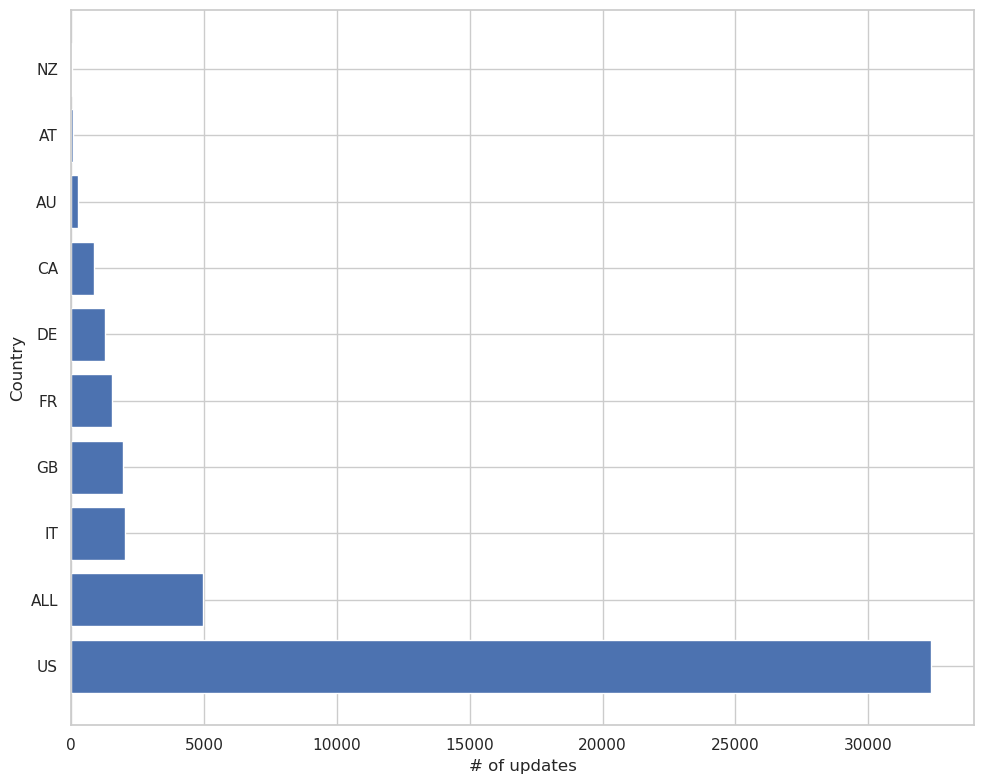

In [98]:
plt.figure(figsize=(10, 8))
country_updates = country_updates\
                    .sort_values("unique", 
                                 ascending=False)

plt.barh(country_updates.index, 
         country_updates["unique"])
plt.xlabel("Number of updates") 
plt.ylabel("Country")
plt.tight_layout()

plt.savefig(join(figures_path, 
                 "updates_per_country.png"), 
                 dpi=300)
plt.show()

In [99]:
unique_updates = df15_UUID\
                    .groupby(["Country", "file_year"])["Last Updated"]\
                    .nunique()\
                    .reset_index()
unique_updates.columns = ["Country", "Year", "Updates"]
unique_updates["Year"] = unique_updates["Year"]\
                            .astype(str)

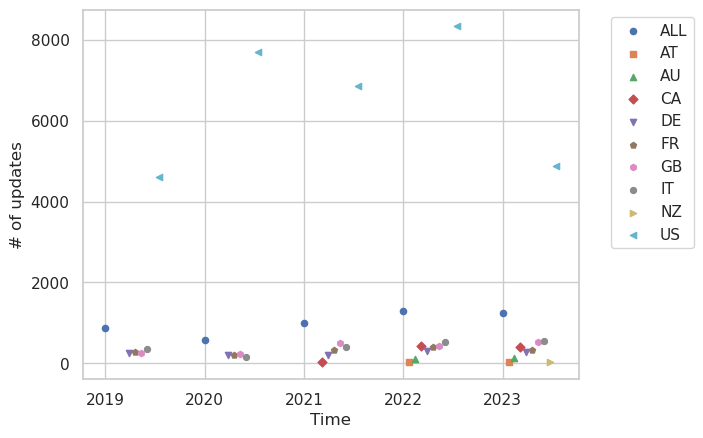

In [100]:
markers = ["o", "s", "^", "D", "v", "p", "h", "8", ">", "<"]
dodge = 0.06
unique_updates["Year"] = pd.to_numeric(
                                unique_updates["Year"], 
                                errors="coerce")

for i, country in enumerate(unique_updates["Country"].unique()):
    country_df = unique_updates[\
                    unique_updates["Country"] == country]
    plt.scatter(
            country_df["Year"] + i * dodge, 
            country_df["Updates"], 
            label=country, 
            marker=markers[i % len(markers)],  
            s=20)
plt.xlabel("Time (years)")
plt.ylabel("Number of updates")
plt.legend(bbox_to_anchor=(1.05, 1), 
           loc="upper left")
plt.savefig(join(figures_path, 
                 "updates_per_country_over_time.png"), 
                 dpi=300)
plt.show()

In [101]:
#merge time_diff_per_country with country_means
country_means = country_means\
                    .merge(time_diff_country, 
                           on="Country")
country_means

,Country,n (\%),Trustworthiness (SD),Updates
0,US,7996 (76.0),62.34 (35.12),303 days
1,GB,621 (5.9),79.64 (21.68),313 days
2,IT,526 (5.0),73.08 (24.33),333 days
3,CA,466 (4.43),86.48 (16.58),371 days
4,FR,431 (4.1),66.47 (29.24),398 days
5,AT,40 (0.38),71.96 (30.74),339 days
6,DE,375 (3.56),78.09 (30.1),403 days
7,NZ,21 (0.2),80.85 (26.53),235 days
8,ALL,1451 (13.79),72.44 (27.9),370 days
9,AU,140 (1.33),71.41 (28.56),304 days


In [102]:
table2_latex = country_means\
    .sort_values("Country", ascending=False)\
    .to_latex(
        index=False, 
        escape=False,
        caption="\\textbf{Country Descriptives.}",
        label="table:table2", 
        position='H',
        column_format=' X c c c c ',
        longtable=False, 
        header=True, 
        na_rep='---', 
        bold_rows=True)

table2_latex = \
    table2_latex\
        .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")

table2_latex = \
    table2_latex\
        .replace("\\end{tabular}", "\\end{tabularx}")

table2_latex = \
    table2_latex \
        .replace("\\bottomrule", 
                 "\\bottomrule\n" 
                 "\\multicolumn{3}{l}{\\textit{Note.} Across all database versions with n = unique number of domains.}"
                 )

with open(join(tables_path, "t2_countries.tex"), 'w') as f:
    f.write(table2_latex)

/tmp/ipykernel_1466227/809750204.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table1_latex = country_means\


## Overlap with other lists

In [103]:
gond = pd.read_csv("../GONDv1_domains.csv")
gond_de = (gond[gond["language"] == "de"]
           .drop_duplicates(
               subset="domain", 
               keep="first")
)
gond_de.head(3)

#overlap between gond and newsguard
df15_de = (df15[df15["Language"] == "de"]
           .drop_duplicates(
               subset="Domain", 
               keep="first")
)
overlap_de = pd.merge(gond_de, df15_de, 
                   left_on="domain", 
                   right_on="Domain",
                   how="inner")
len(overlap_de)

df15_unique = \
    df15\
    .drop_duplicates(
        subset="Domain", 
        keep="first")

gond_unqiue = \
    gond\
    .drop_duplicates(
        subset="domain", 
        keep="first")

overlap = pd.merge(gond, df15_unique, 
                   left_on="domain", 
                   right_on="Domain",
                   how="inner")

len(overlap)

543

## Political Orientation

In [104]:
print(f'Out of {len(df15)} rows, '
      f'{df15["Orientation"].isnull().sum()} '
      'have no rating for orientation.')
print(f'Out of {len(df15_UUID)} unique ratings, '
      f'{df15_UUID["Orientation"].isnull().sum()} '
      'have no rating for orientation.')
print(f'This is {round(df15_UUID["Orientation"].isnull().sum()/len(df15_UUID)*100,2)}% '
      'of the unique ratings.')

Out of 421870 rows, 283907 have no rating for orientation.
Out of 45294 unique ratings, 27094 have no rating for orientation.
This is 59.82% of the unique ratings.


In [108]:
print(f'In the most recent database, '
      f'{most_recent["Orientation"].isnull().sum()} '
      'have no rating for orientation.\n'
      f'Out of {len(most_recent)} rows, '
      f'{most_recent["Orientation"].notnull().sum()} have a rating.\n'
      f'This is {round(most_recent["Orientation"].notnull().sum()/len(most_recent)*100,2)}% '
      'of the unique ratings.')

In the most recent database, 6578 have no rating for orientation.
Out of 9558 rows, 2980 have a rating.
This is 31.18% of the unique ratings.


In [127]:
total_per_country = \
    most_recent\
        .groupby("Country")\
        .size()\
        .reset_index(name="Total")

orientation_count = \
    most_recent[most_recent["Orientation"].notnull()]\
        .groupby("Country")\
        .size()\
        .reset_index(name="Orientation")

country_counts = \
    total_per_country\
        .merge(orientation_count, 
               on="Country", 
               how="left")

country_counts["Percentage"] = \
    round((country_counts["Orientation"] / country_counts["Total"]) * 100,2)

country_counts

,Country,Total,Orientation,Percentage
0,ALL,1136,153,13.47
1,AT,38,10,26.32
2,AU,116,21,18.10
3,CA,435,14,3.22
4,DE,292,47,16.10
5,FR,308,47,15.26
6,GB,470,46,9.79
7,IT,459,53,11.55
8,NZ,18,3,16.67
9,US,6286,2586,41.14


In [118]:
#how many rows are there per country?
most_recent\
    .groupby("Country")\
    .size()\
    .reset_index(name="Count")

,Country,Count
0,ALL,1136
1,AT,38
2,AU,116
3,CA,435
4,DE,292
5,FR,308
6,GB,470
7,IT,459
8,NZ,18
9,US,6286


In [110]:
#count orientation per country
orientation_countries = \
    most_recent\
        .groupby("Country")["Orientation"]\
        .value_counts()\
        .unstack(fill_value=1)

#add number of orientation ratings per country
orientation_countries["Total"] = \
    most_recent\
        .groupby("Country")["Orientation"]\
        .count()
        

orientation_countries["% right"] = \
    (orientation_countries["Right"]/orientation_countries["Total"]*100)\
        .round(2)


orientation_countries["Right"] = \
    orientation_countries["Right"].astype(str) + \
    " (" + orientation_countries["% right"].astype(str) + ")"

orientation_countries["% left"] = \
    (orientation_countries["Left"]/orientation_countries["Total"]*100)\
        .round(2)

orientation_countries["Left"] = \
    orientation_countries["Left"].astype(str) + \
    " (" + orientation_countries["% left"].astype(str) + ")"

#drop columns
orientation_countries = \
    orientation_countries\
        .drop(["% right", "% left"], axis=1)\
        .rename(columns={"Left":"Left (%)", "Right":"Right (%)"})

orientation_countries

Orientation,Left (%),Right (%),Total
Country,,,
ALL,36 (23.53),117 (76.47),153
AT,2 (20.0),8 (80.0),10
AU,8 (38.1),13 (61.9),21
CA,4 (28.57),10 (71.43),14
DE,9 (19.15),38 (80.85),47
FR,16 (34.04),31 (65.96),47
GB,22 (47.83),24 (52.17),46
IT,11 (20.75),42 (79.25),53
NZ,1 (33.33),2 (66.67),3


In [111]:
#latex table
table3_latex = \
    orientation_countries\
        .sort_values("Country", ascending=False)\
        .to_latex(index=True, 
                  escape=False,
                  caption="\\textbf{Orientation per country.}",
                  label="table:table3", 
                  position='H',
                  column_format=' X c c c',
                  longtable=False, 
                  header=True, 
                  na_rep='---', 
                  bold_rows=True)

table3_latex = \
    table3_latex\
        .replace("\\begin{tabular}{", 
                 "\\begin{tabularx}{\\textwidth}{")
table3_latex = \
    table3_latex\
        .replace("\\end{tabular}", 
                 "\\end{tabularx}")

table3_latex = \
    table3_latex\
        .replace("\\bottomrule", 
                 "\\bottomrule\n"
                 "\\multicolumn{5}{l}{\\textit{Note.} Most recent database.}")

#replace all % with \%
table3_latex = \
    table3_latex\
        .replace("%", "\%")

with open(join(tables_path, 
               "t3_orientation_countries.tex"), 
               'w') as f:
    f.write(table3_latex)

/tmp/ipykernel_1466227/1938731108.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  orientation_countries\


<Axes: xlabel='file_month'>

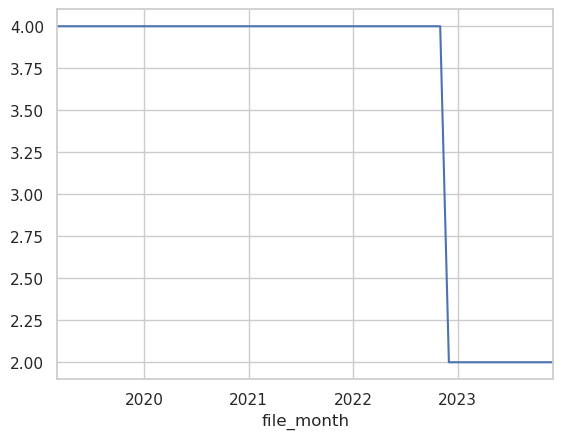

In [128]:
df15\
    .groupby("file_month")["Orientation"]\
    .nunique()\
    .plot(kind="line")

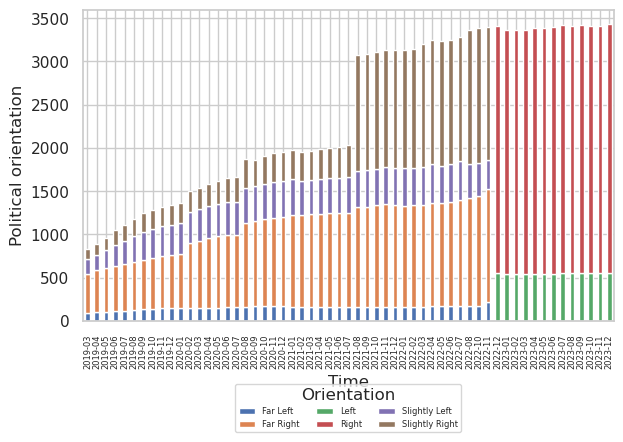

In [129]:
df15\
    .groupby("file_month")["Orientation"]\
    .value_counts(normalize=False)\
    .unstack()\
    .plot(kind="bar", stacked=True)
plt.xlabel("Time (months)")
plt.ylabel("Political orientation")
plt.xticks(fontsize=6)
plt.legend(title="Orientation", 
           loc="lower center", 
           bbox_to_anchor=(0.5, -0.37), 
           ncol=3, fontsize=6)
plt.tight_layout()

plt.savefig(join(figures_path,"orientation_over_time.png"), 
            dpi=300)

In [130]:
for df in [df15, df15_UUID]:
    df["Orientation_bi"] = df["Orientation"]\
        .replace(
        {"Far Left": "Left", "Slightly Left": "Left", 
         "Slightly Right": "Right", 
         "Far Right": "Right"})

left_right_count = df15["Orientation_bi"]\
    .value_counts()\
    .reset_index()

left_right_count["%"] = \
    (left_right_count["Orientation_bi"] / left_right_count["Orientation_bi"].sum() * 100)\
        .round(2)

left_right_count

,index,Orientation_bi,%
0,Right,107575,77.97
1,Left,30388,22.03


In [131]:
score_x_orientation_time = df15\
    .groupby(["file_date", "Orientation"])["Score"]\
    .agg(["mean", "std"])

score_x_orientation_time.tail(2)

mean        std
file_date           Orientation                      
2023-12-15 01:00:00 Left         61.113514  25.991107
                    Right        27.364066  20.423941

In [132]:
score_x_orientation_time_bi = df15\
    .groupby(["file_date", "Orientation_bi"])["Score"]\
    .agg(["mean", "std"])

score_x_orientation_time_bi\
    .groupby("Orientation_bi")["mean"]\
    .mean() 

Orientation_bi
Left     71.089262
Right    28.007480
Name: mean, dtype: float64

In [133]:
score_x_orientation_time_bi\
    .groupby("Orientation_bi")["std"]\
    .mean()

Orientation_bi
Left     25.212816
Right    26.564160
Name: std, dtype: float64

/tmp/ipykernel_1466227/4276959947.py:17: UserWarning: The label '_child6' of <matplotlib.lines.Line2D object at 0x7fa4cbeded30> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles=ax.lines + legend_lines,


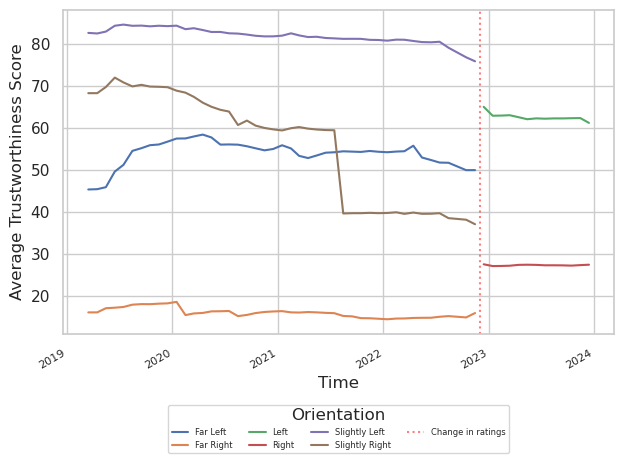

In [139]:
ax = score_x_orientation_time["mean"]\
    .unstack()\
    .plot(kind="line")
plt.xlabel("Time (years)")
plt.ylabel("Average Trustworthiness")
plt.xticks(fontsize=8)
plt.axvline(x="2022-12", 
            color="red", 
            linestyle="dotted", 
            alpha=0.5)
legend_lines = [Line2D([0], [0], 
                       color="red", 
                       linestyle="dotted", 
                       alpha=0.5, 
                       label="Change in ratings")]

ax.legend(handles=ax.lines + legend_lines, 
          title="Orientation", 
          loc="lower center", 
          bbox_to_anchor=(0.5, -0.38), 
          ncol=4, 
          fontsize=6)
plt.tight_layout()
plt.savefig(join(figures_path,
                 "f6-scores_orientation_over_time.png"),
            dpi=300)

In [140]:
score_x_orientation_time\
    .loc["2021-06":"2021-08"]

mean        std
file_date           Orientation                         
2021-06-15 01:00:00 Far Left        54.022876  27.760272
                    Far Right       15.903256  20.758654
                    Slightly Left   81.323821  18.353697
                    Slightly Right  59.407563  30.834733
2021-07-15 01:00:00 Far Left        54.123377  27.659420
                    Far Right       15.826350  20.701533
                    Slightly Left   81.230488  18.446345
                    Slightly Right  59.368493  30.881606
2021-08-15 01:00:00 Far Left        54.353896  27.642733
                    Far Right       15.164336  19.691632
                    Slightly Left   81.118644  18.406131
                    Slightly Right  39.556597  20.297690

In [141]:
score_x_orientation_time\
    .groupby("Orientation")["mean"]\
    .describe()

,count,mean,std,min,25%,50%,75%,max
Orientation,,,,,,,,
Far Left,44.0,53.824213,3.076220,45.268421,52.841395,54.362483,55.795686,58.331081
Far Right,44.0,15.937800,1.131637,14.377902,15.044728,15.892768,16.291120,18.518341
Left,13.0,62.484190,0.872396,61.113514,62.181319,62.229358,62.821229,64.938757
Right,13.0,27.240150,0.125276,27.039936,27.146089,27.223841,27.323509,27.462526
Slightly Left,44.0,81.876337,1.836099,75.776119,80.925754,81.864086,82.940109,84.511070
Slightly Right,44.0,56.128234,12.813416,37.000328,39.665662,59.883686,68.188914,71.892638


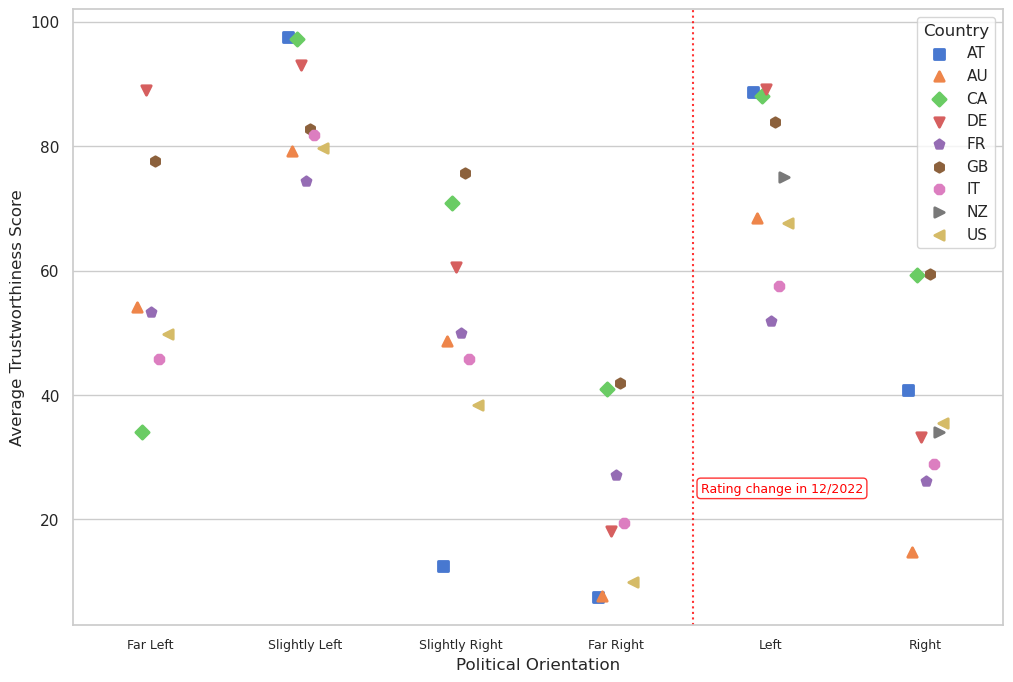

In [142]:
plt.figure(figsize=(12, 8))

country_markers = ["s", "^", "D", "v", "p", "h", "8", ">", "<"]

sns.pointplot(x="Orientation", y="Score", 
               hue="Country", 
               data=df15_UUID[df15_UUID["Country"] != 'ALL'], 
               markers=country_markers,
               order=["Far Left", "Slightly Left", 
                      "Slightly Right", "Far Right", 
                      "Left", "Right"],
               hue_order=sorted(df15_UUID[df15_UUID["Country"] != 'ALL']["Country"].unique()),
               palette="muted", 
               errorbar=None,
               #split=False,
               #width=0.8
               dodge=True,
               join=False)

plt.axvline(x=3.5,
            color="red", 
            linestyle="dotted", 
            label="Rating changed in 12/2022", 
            alpha=0.8)
plt.xlabel("Political Orientation")
plt.xticks(fontsize=9)
plt.ylabel("Average Trustworthiness")

#add a text box to line
plt.text(3.55, 25, "Rating change in 12/2022", 
         fontsize=9, 
         color="red",
         verticalalignment="center", 
         bbox=dict(facecolor="none", edgecolor="red",
                   boxstyle="round,pad=0.3",
                   alpha=0.8))

#legend below
#plt.legend(loc="lower center", 
#           bbox_to_anchor=(0.5, -0.1), 
#           ncol=5, fontsize=8)

plt.savefig(join(figures_path,
                 "f7-scores_orientation_per_country.png"),
                 dpi=300)

plt.show()

In [143]:
#country average score per orientation over time
score_x_orientation_time_country = df15\
    .groupby(["Country", "file_date", "Orientation_bi"])["Score"]\
    .agg(['mean', 'std'])\
    .reset_index()
score_x_orientation_time_country

,Country,file_date,Orientation_bi,mean,std
0,ALL,2019-05-15 01:00:00,Left,89.285714,10.676521
1,ALL,2019-05-15 01:00:00,Right,46.400000,33.881042
2,ALL,2019-06-15 01:00:00,Left,91.370968,9.283469
3,ALL,2019-06-15 01:00:00,Right,62.666667,36.081028
4,ALL,2019-07-15 01:00:00,Left,88.404255,15.537696
...,...,...,...,...,...
789,US,2023-10-15 01:00:00,Right,26.472052,19.131685
790,US,2023-11-15 01:00:00,Left,60.146739,22.831427
791,US,2023-11-15 01:00:00,Right,26.551871,19.219462
792,US,2023-12-15 01:00:00,Left,58.368074,23.556327


In [144]:
countries = \
    score_x_orientation_time_country['Country']\
    .unique()
filtered_countries = countries[countries != "ALL"]

In [145]:
score_x_orientation_time_country

,Country,file_date,Orientation_bi,mean,std
0,ALL,2019-05-15 01:00:00,Left,89.285714,10.676521
1,ALL,2019-05-15 01:00:00,Right,46.400000,33.881042
2,ALL,2019-06-15 01:00:00,Left,91.370968,9.283469
3,ALL,2019-06-15 01:00:00,Right,62.666667,36.081028
4,ALL,2019-07-15 01:00:00,Left,88.404255,15.537696
...,...,...,...,...,...
789,US,2023-10-15 01:00:00,Right,26.472052,19.131685
790,US,2023-11-15 01:00:00,Left,60.146739,22.831427
791,US,2023-11-15 01:00:00,Right,26.551871,19.219462
792,US,2023-12-15 01:00:00,Left,58.368074,23.556327


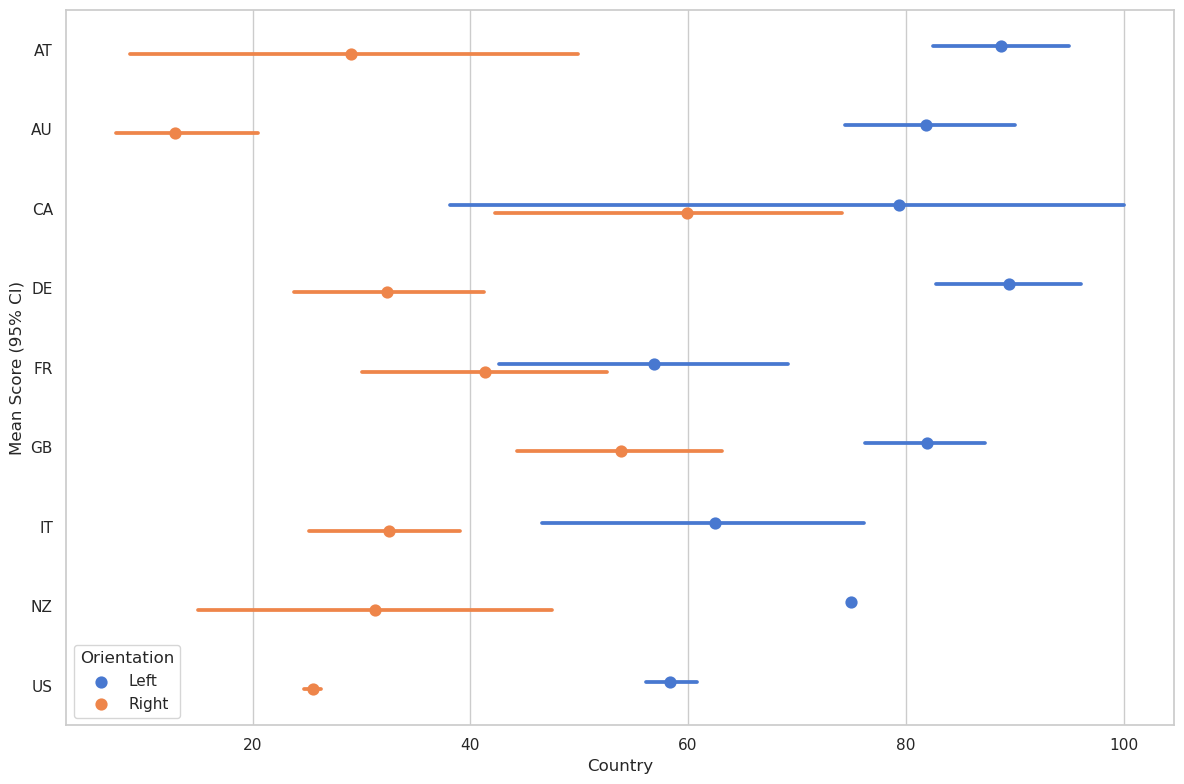

In [217]:
plt.figure(figsize=(12, 8))
country_diff = most_recent[most_recent["Country"] != "ALL"]

sns.pointplot(
    data=country_diff, 
    y="Country", 
    x="Score", 
    hue="Orientation", 
    hue_order=["Left", "Right"],
    order=sorted(country_diff["Country"].unique()),
    errorbar="ci",
    palette="muted",
    join=False,
    dodge=0.1)

plt.xlabel("Trustworthiness (95% CI)")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig(join(figures_path,
                    "fa4-scores_orientation_per_country_95.png"),
                    dpi=300)
plt.show()

In [151]:
most_recent\
    .groupby("Orientation")["Score"]\
    .describe()

,count,mean,std,min,25%,50%,75%,max
Orientation,,,,,,,,
Left,423.0,61.676123,23.357774,7.5,39.5,62.5,80.0,100.0
Right,2557.0,26.654478,20.134820,0.0,7.5,32.0,32.0,100.0


In [147]:
ttest_recent = \
    stats\
        .ttest_ind(
            most_recent[most_recent["Orientation"] == "Left"]["Score"], 
            most_recent[most_recent["Orientation"] == "Right"]["Score"],
            nan_policy="omit")

ttest_recent

TtestResult(statistic=32.35409531400827, pvalue=4.6620855020667373e-197, df=2978.0)

In [148]:
ttest_all = \
    stats\
        .ttest_ind(
            df15_UUID[df15_UUID["Orientation_bi"] == "Left"]["Score"], 
            df15_UUID[df15_UUID["Orientation_bi"] == "Right"]["Score"],
            nan_policy="omit")

ttest_all

TtestResult(statistic=100.55645937739614, pvalue=0.0, df=18103.0)

## Topics

In [154]:
print(
    f'Out of {df15_UUID["UUID"].nunique()} unique ratings, '
    f'there are {df15_UUID["Topics"].isnull().sum()} without topic. ')

print(
    f'This makes up {round(df15_UUID["Topics"].isnull().sum()/df15_UUID["UUID"].nunique()*100,2)}% ')

Out of 45294 unique ratings, there are 18266 without topic. 
This makes up 40.33% 


<Axes: xlabel='file_date'>

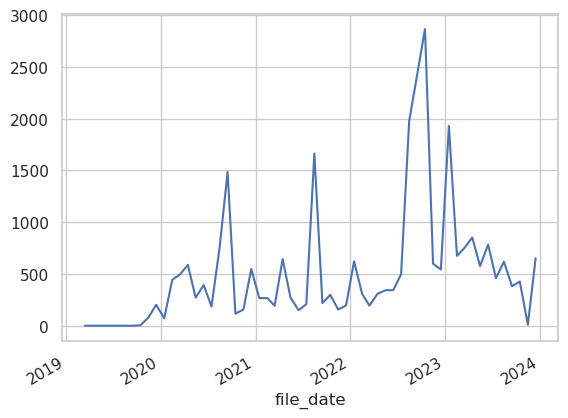

In [160]:
df15_UUID\
    .groupby("file_date")["Topics"]\
    .count()\
    .plot(kind="line")

In [161]:
domain_count_without_topics = \
    len(most_recent[most_recent["Topics"]\
        .isnull()]\
        .groupby("Domain")\
        .size()\
        .reset_index(name="Count"))

print(
    f'Out of {most_recent["Domain"].nunique()} unique domains, '
    f'there are {domain_count_without_topics} without topic. '
    f'This makes up {round(domain_count_without_topics/most_recent["Domain"].nunique()*100,2)}% ')

Out of 8416 unique domains, there are 146 without topic. This makes up 1.73% 


In [208]:
recent_topics_df = \
    most_recent[[
        "Domain", "Country", "Topics",
        "Orientation", "Score", "Rating"]]

recent_topics_df\
    .reset_index(drop=True, 
                 inplace=True)  

recent_topics_df["Topics"] = \
    most_recent["Topics"]\
        .str.split(",")  #split topics into lists

recent_topics_df.head(3)

/tmp/ipykernel_1466227/1281062945.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_topics_df["Topics"] = \


,Domain,Country,Topics,Orientation,Score,Rating
0,peterboroughtoday.co.uk,GB,"[Local News, General News]",NaN,82.5,T
1,mycharisma.com,US,[Religion],NaN,49.5,N
2,charismamag.com,US,[Religion],NaN,49.5,N


In [209]:
recent_topics_df = \
    recent_topics_df\
        .explode("Topics")\
        .reset_index(drop=True)

recent_topics_df.head(3)

,Domain,Country,Topics,Orientation,Score,Rating
0,peterboroughtoday.co.uk,GB,Local News,NaN,82.5,T
1,peterboroughtoday.co.uk,GB,General News,NaN,82.5,T
2,mycharisma.com,US,Religion,NaN,49.5,N


In [210]:
recent_topic_count = \
    recent_topics_df\
        .groupby("Topics")\
        .size()\
        .reset_index()

recent_topic_count["%"] = \
    (recent_topic_count[0] / len(most_recent) * 100)\
        .round(2)

recent_topic_count\
    .columns = ["Topics", "Count", "%"]

recent_topic_avg = \
    recent_topics_df\
        .groupby("Topics")["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

recent_topic_avg\
    .columns = ["Topics", "Score", "SD"]

recent_topic_desc = \
    pd.merge(recent_topic_count,
             recent_topic_avg,
            on="Topics")

recent_topic_desc\
    .sort_values("Count", ascending=False)\
    .head(5) 

,Topics,Count,%,Score,SD
11,Local News,3734,39.07,63.03,30.72
14,Political news or commentary,3621,37.88,61.45,30.92
8,General News,1900,19.88,68.08,30.29
9,Health or medical information,1006,10.53,67.75,31.48
2,Conspiracy theories or hoaxes,909,9.51,68.27,31.42


In [212]:
recent_topic_desc = \
    recent_topic_desc\
        .sort_values("Score", 
                     ascending=False)
recent_topic_desc.tail(3)

,Topics,Count,%,Score,SD
11,Local News,3734,39.07,63.03,30.72
14,Political news or commentary,3621,37.88,61.45,30.92
12,Military and Defense,46,0.48,58.25,39.64


In [190]:
recent_topic_desc.head(3)

,Topic,Count,%,Score,SD
4,Education,23,0.24,90.22,10.92
0,Business or Personal Finance,23155,242.26,87.53,2.31
8,General News,22373,234.08,83.32,14.33


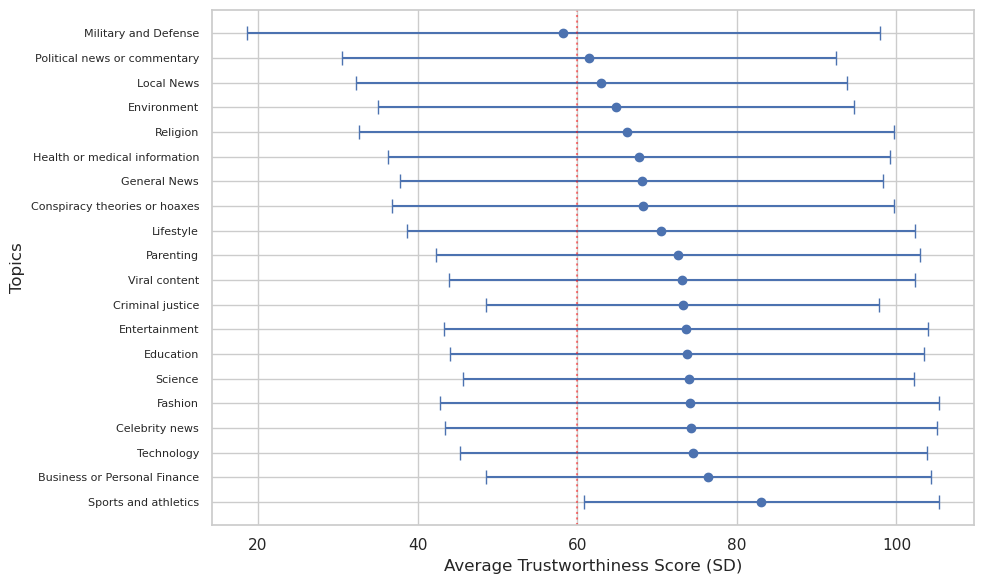

In [216]:
plt.figure(figsize=(10, 6))
plt.errorbar(y=recent_topic_desc["Topics"],
            x=recent_topic_desc["Score"],
            xerr=recent_topic_desc["SD"],
            fmt="o", capsize=5)

plt.axvline(x=60, 
            color="red", 
            linestyle="dotted", 
            label="Trustworthiness threshold", 
            alpha=0.5)

plt.xlabel("Average Trustworthiness (SD)")
plt.ylabel("Topic")
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(join(figures_path, 
                 "f8-topics_score_recent.png"), 
                 dpi=300)
plt.show()

### Over time

In [179]:
topics_df = df15_UUID\
    .set_index("UUID")["Topics"]\
    .str.split(",", expand=True)\
    .stack()\
    .reset_index(level=1, drop=True)\
    .reset_index()
topics_df.columns = ["UUID", "Topic"]
topics_df.head(3)

,UUID,Topic
0,c1807f28-d3bc-4873-8011-bc194e951755,Health or medical information
1,62ea708e-787b-43cf-92d1-1b9911f80b77,Health or medical information
2,c3b20334-74c8-42fa-b6e7-efa6d44dddd6,Health or medical information


In [180]:
topics_df = pd.merge(
    df15_UUID[["UUID", "Domain", "Country", 
               "Orientation", "Score", "Rating",
               "file_date"]], 
    topics_df, 
    on="UUID",
    how="right")

topics_df.head(3)

,UUID,Domain,Country,Orientation,Score,Rating,file_date,Topic
0,c1807f28-d3bc-4873-8011-bc194e951755,chop.edu,US,NaN,77.5,T,2019-10-15 01:00:00,Health or medical information
1,62ea708e-787b-43cf-92d1-1b9911f80b77,healthylifeboxx.com,US,NaN,20.0,N,2019-10-15 01:00:00,Health or medical information
2,c3b20334-74c8-42fa-b6e7-efa6d44dddd6,cancer.net,US,NaN,77.5,T,2019-10-15 01:00:00,Health or medical information


In [182]:
topic_count = topics_df\
    .groupby("Topic")\
    .size()\
    .reset_index()

#add percentage 
topic_count["%"] = \
    (topic_count[0] / df15_UUID["UUID"].nunique() * 100)\
        .round(2)

topic_count.columns = ["Topic", "Count", "%"]

topic_avg = topics_df\
    .groupby("Topic")["Score"]\
    .agg(["mean", "std"])\
    .reset_index()\
    .round(2)

topic_avg.columns = ["Topic", "Score", "SD"]

topic_descriptives = pd.merge(topic_count,
                                topic_avg,
                                on="Topic")

topic_descriptives\
    .sort_values("Count", ascending=False)\
    .head(5)

,Topic,Count,%,Score,SD
17,Political news or commentary,17255,38.10,35.10,30.51
3,Conspiracy theories or hoaxes,8098,17.88,10.76,11.20
11,Health or medical information,7821,17.27,28.27,33.16
1,COVID-19 misinformation,4710,10.40,15.70,15.63
13,Local News,2571,5.68,87.67,12.96


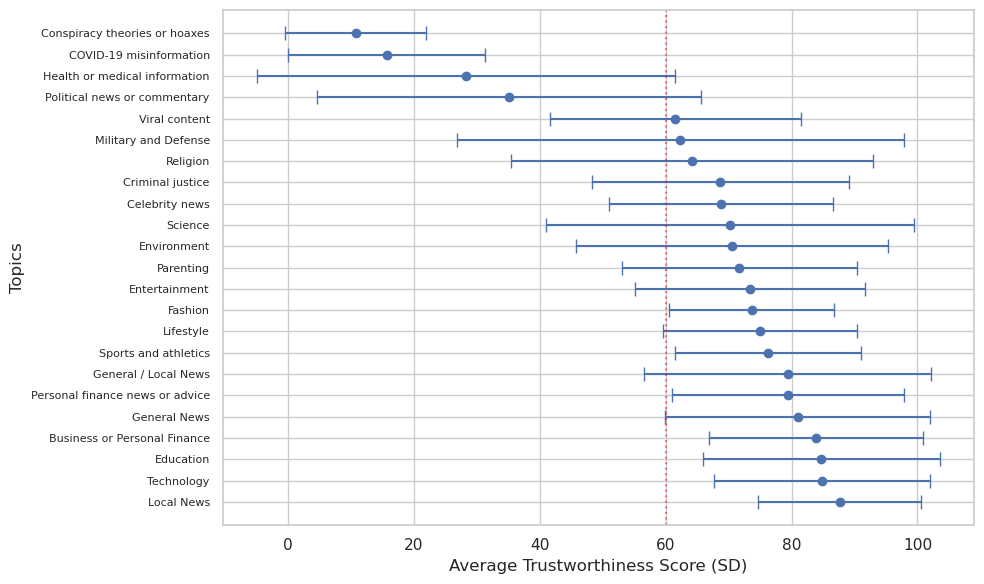

In [184]:
topic_descriptives = \
    topic_descriptives\
        .sort_values("Score", 
                     ascending=False)

plt.figure(figsize=(10, 6))
plt.errorbar(y=topic_descriptives["Topic"],
            x=topic_descriptives["Score"],
            xerr=topic_descriptives["SD"],
            fmt="o", capsize=5)

plt.axvline(x=60, 
            color="red", 
            linestyle="dotted", 
            label="Trustworthiness threshold", 
            alpha=0.5)

plt.xlabel("Average Trustworthiness (SD)")
plt.ylabel("Topic")
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(join(figures_path, 
                 "f8-topics_score_time.png"), 
                dpi=300)
plt.show()

In [185]:
#how many bad domains cover each topic?
bad_ratings = topics_df[topics_df["Rating"] == "N"]
bad_domains = bad_ratings["Domain"].nunique()

bad_domains_per_topic = \
    bad_ratings\
        .groupby("Topic")["Domain"]\
        .nunique()\
        .reset_index()\
        .rename(columns={"Domain": "Untrustworthy Domains"})\
        .sort_values("Untrustworthy Domains", ascending=False)\
        .assign(
            Percentage=lambda x: (x["Untrustworthy Domains"] / bad_domains * 100)\
            .round(2))
bad_domains_per_topic.head(5)

,Topic,Untrustworthy Domains,Percentage
17,Political news or commentary,3063,79.81
1,COVID-19 misinformation,1962,51.12
3,Conspiracy theories or hoaxes,1452,37.83
11,Health or medical information,967,25.20
9,General / Local News,178,4.64


In [132]:
domains_per_topic = \
    topics_df\
        .groupby("Topic")["Domain"]\
        .nunique()\
        .reset_index()\
        .rename(columns={"Domain": "Unique Domains"})\
        .sort_values("Unique Domains", ascending=False)\
        .assign(
            Percentage=lambda x: (x["Unique Domains"] / topics_df["Domain"].nunique() * 100)\
            .round(2))
domains_per_topic.head(5)

,Topic,Unique Domains,Percentage
17,Political news or commentary,4350,48.33
13,Local News,2037,22.63
1,COVID-19 misinformation,2020,22.44
10,General News,1681,18.68
11,Health or medical information,1598,17.75


In [133]:
bad_topics = topics_df\
    .groupby("Topic")["Rating"]\
    .value_counts(normalize=True)\
    .unstack()\
    .reset_index()\
    .sort_values("N", ascending=False)\
    .head(5)
bad_topics


Rating,Topic,FL,N,P,S,T
3,Conspiracy theories or hoaxes,0.000123,0.986416,0.007286,NaN,0.006174
1,COVID-19 misinformation,NaN,0.969639,0.006794,NaN,0.023567
17,Political news or commentary,0.001101,0.777572,0.003535,0.000232,0.217560
11,Health or medical information,0.003452,0.753101,0.009462,0.001279,0.232707
22,Viral content,0.010949,0.456204,0.007299,0.003650,0.521898


In [134]:
country_topics = topics_df\
    .groupby(["Country", "Topic"])\
    .size()\
    .reset_index(name="Count")

ratings_per_country = \
    topics_df\
        .groupby("Country")["UUID"]\
        .nunique()

country_topics = pd.merge(
    country_topics, 
    ratings_per_country.reset_index(), 
    on="Country", 
    how="left")

country_topics["Percentage"] = \
    (country_topics["Count"] / country_topics["UUID"] * 100)\
        .round(2)

country_topics\
    .drop("UUID", 
          axis=1, 
          inplace=True)

In [135]:
topic_avg = \
    topics_df\
        .groupby(["Country", "Topic"])["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

topic_avg.columns = \
    ["Country", "Topic", "Score", "SD"]

topic_descriptives = \
    pd.merge(
        country_topics, 
        topic_avg, 
        on=["Country", "Topic"])

result_sorted = topic_descriptives\
    .sort_values(["Country", "Count"], 
                ascending=[True, False])
result_sorted.head(2)

,Country,Topic,Count,Percentage,Score,SD
17,ALL,Political news or commentary,1451,48.82,57.91,36.52
11,ALL,Health or medical information,740,24.90,51.89,33.60


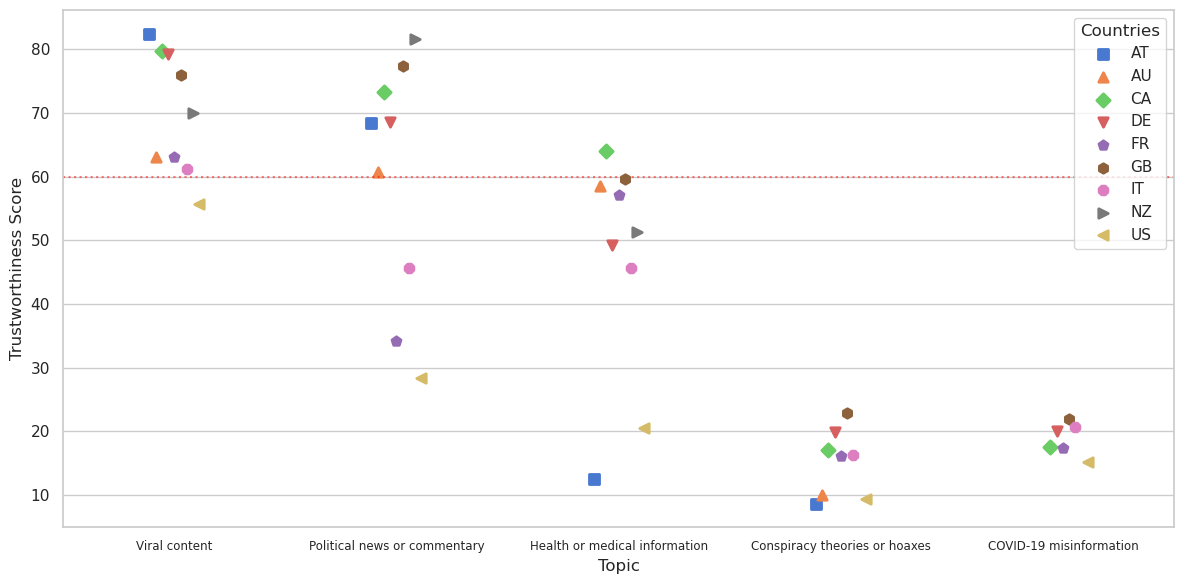

In [136]:
result_countries = (
    result_sorted[result_sorted["Country"] != "ALL"]
    .loc[result_sorted["Topic"].isin(bad_topics["Topic"].unique()), :]
).sort_values("Score", ascending=False)

plt.figure(figsize=(12, 6))
sns.pointplot(x="Topic", 
            y="Score",
            hue="Country",
            hue_order=sorted(result_countries["Country"].unique()),
            data=result_countries, 
            dodge=True,
            markers = country_markers,
            join=False,
            palette="muted",
            #order=bad_topics["Topic"].unique()
            )

plt.axhline(y=60,
            color="red", 
            linestyle="dotted", 
            alpha=0.5)

plt.xlabel("Topic")
plt.xticks(fontsize=8.5)
plt.ylabel("Trustworthiness")
plt.legend(title="Countries",
           loc="upper right", 
           ncol=1)
plt.tight_layout()
plt.savefig(join(figures_path, "f9-topics_score_per_country.png"),
            dpi=300)
plt.show()

In [137]:
#which topic has the highest variance?
topics_df\
    .groupby("Topic")["Score"]\
    .var()\
    .reset_index()\
    .sort_values("Score", ascending=False)\
    .head(5)

,Topic,Score
14,Military and Defense,1261.318293
11,Health or medical information,1099.782467
17,Political news or commentary,930.901625
19,Science,858.295418
18,Religion,826.821070


In [138]:
result_sorted[result_sorted["Topic"] == "Health or medical information"]\
    .sort_values("Score", ascending=False)

,Country,Topic,Count,Percentage,Score,SD
70,CA,Health or medical information,58,12.95,64.00,34.55
136,GB,Health or medical information,244,26.35,59.63,32.15
49,AU,Health or medical information,21,8.97,58.52,35.25
113,FR,Health or medical information,310,37.30,57.20,30.02
11,ALL,Health or medical information,740,24.90,51.89,33.60
177,NZ,Health or medical information,2,7.69,51.25,37.12
91,DE,Health or medical information,205,21.58,49.30,36.40
158,IT,Health or medical information,270,24.37,45.60,33.68
195,US,Health or medical information,5969,30.64,20.55,29.01
30,AT,Health or medical information,2,3.64,12.50,0.00


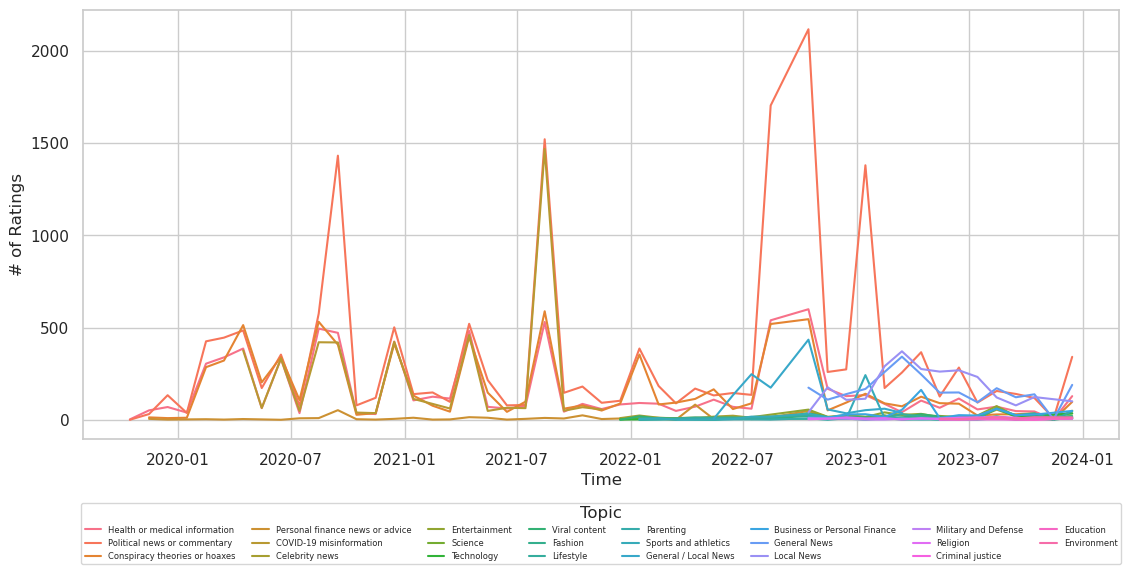

In [139]:
#topic frequency over time
topic_freq = topics_df\
    .groupby(["file_date", "Topic"])["UUID"]\
    .nunique()\
    .reset_index(name="Count")

plt.figure(figsize=(12, 6))
sns.lineplot(x="file_date", 
             y="Count", 
             hue="Topic", 
             data=topic_freq)
plt.xlabel("Time (months)")
plt.ylabel("Number of ratings")
plt.legend(title="Topic",
           loc="lower center", 
           bbox_to_anchor=(0.5, -0.3), 
           ncol=8, 
           fontsize=6)
plt.tight_layout()

plt.savefig(join(figures_path, 
                "fa3-topics_over_time.png"),
                dpi=300)
plt.show()

In [140]:
#show me the max count for covid-19 misinformation
topic_freq[topic_freq["Topic"] == "Health or medical information"]\
    .sort_values("Count", ascending=False)\
    .head(5)

,file_date,Topic,Count
245,2022-10-15 01:00:00,Health or medical information,600
229,2022-08-15 01:00:00,Health or medical information,540
103,2021-08-15 01:00:00,Health or medical information,531
43,2020-08-15 01:00:00,Health or medical information,495
83,2021-04-15 01:00:00,Health or medical information,483


In [141]:
#topics and orientation overlap
topics_df["Orientation_bi"] = \
    topics_df["Orientation"]\
        .replace(
        {"Far Left": "Left", 
        "Slightly Left": "Left", 
        "Slightly Right": "Right", 
        "Far Right": "Right"})

topics_orientation = \
    topics_df\
        .groupby(["Orientation_bi", "Topic"])["UUID"]\
        .nunique()\
        .reset_index(name="Count")

mean_scores = \
    topics_df\
        .groupby(["Orientation_bi", "Topic"])["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

mean_scores.columns = \
    ["Orientation_bi", "Topic", "Score", "SD"]

topics_orientation = pd.merge(
    topics_orientation, 
    mean_scores, 
    on=["Orientation_bi", "Topic"])

heatmap_count = \
    topics_orientation\
        .pivot_table(
            values="Count", 
            index="Topic", 
            columns="Orientation_bi",
            fill_value=0)

heatmap_score = \
    topics_orientation\
        .pivot_table(
            values="Score", 
            index="Topic", 
            columns="Orientation_bi")

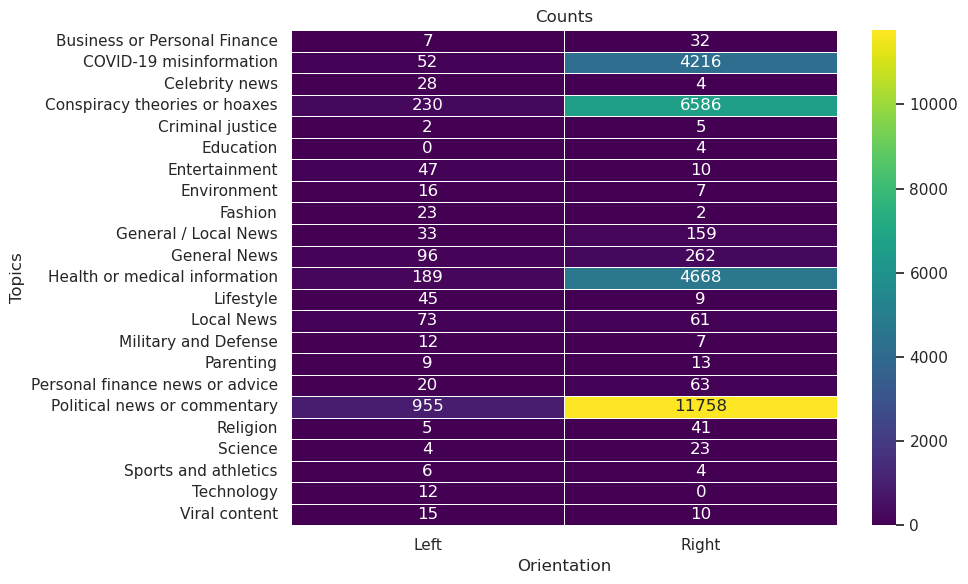

In [142]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_count, 
            annot=True, 
            cmap="viridis", 
            fmt="g", 
            linewidths=.5)
plt.title("Counts")
plt.xlabel("Orientation")
plt.ylabel("Topics")

plt.tight_layout()
plt.show()

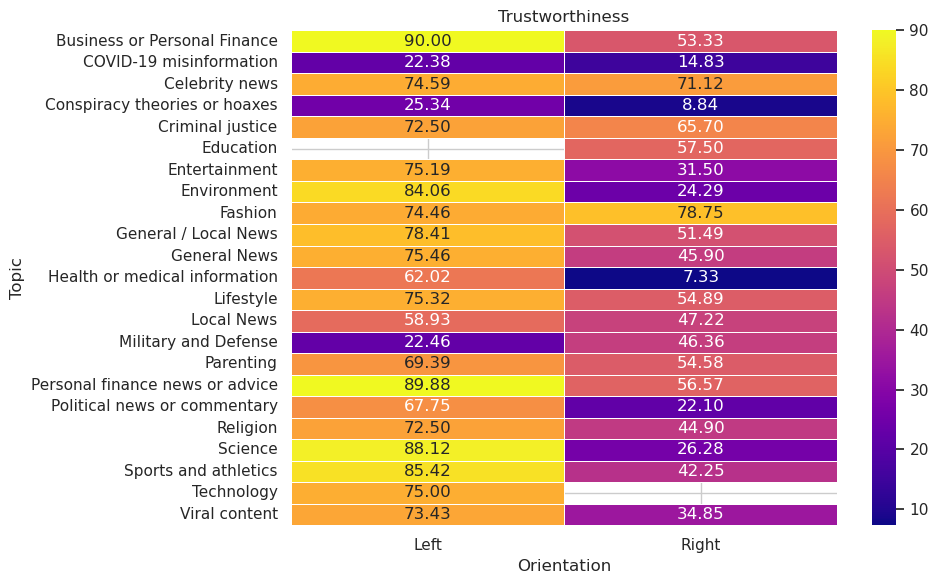

In [143]:
plt.figure(figsize=(10, 6))

sns.heatmap(heatmap_score, 
            annot=True, 
            cmap="plasma", 
            fmt=".2f", 
            linewidths=.5)
plt.title("Trustworthiness")
plt.xlabel("Orientation")
plt.ylabel("Topic")
plt.tight_layout()
plt.savefig(join(figures_path,
                "f10-topics_orientation.png"),
                dpi=300)
plt.show()

## Other variables

In [144]:
most_recent.Flags.value_counts().head(10)

hideParty,covid,vacc,hlth,PartisanLocal          1073
covid,abortion,hlth,ukraine,elec,vacc,climate     458
dead                                              166
plag,dead                                         154
ukraine                                           152
elec,covid                                        136
plag                                              111
covid,hlth,vacc                                    76
hideParty                                          72
dead,hoax                                          65
Name: Flags, dtype: int64

<Axes: xlabel='file_date'>

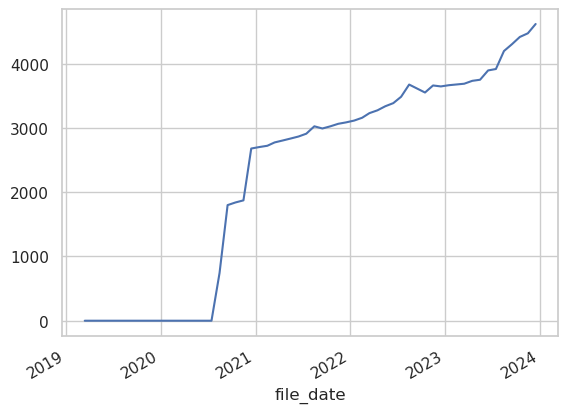

In [145]:
#create variable with 0 or 1
df15["flags_int"] = \
    df15["Flags"]\
        .notnull()\
        .astype(int)

df15\
    .groupby("file_date")["flags_int"]\
    .sum()\
    .plot(kind="line")

In [146]:
df15[df15["flags_int"] == 1]\
    .groupby("file_date")["flags_int"]\
    .sum()\
    .head(3)

file_date
2020-08-15 01:00:00     743
2020-09-15 01:00:00    1800
2020-10-15 01:00:00    1841
Name: flags_int, dtype: int64

In [147]:
df_total["myths"].value_counts()

102431f3-d621-4ba4-ae4b-ab7da59d74d5,7e61e4a4-8409-4290-9ef6-3f54753ec548,33180d69-cfb3-46cb-af1a-3354fb13e887,d7567bf3-d02a-4593-95d8-846c181fe588,79f635e6-94ed-44ed-b7b9-61c35536291c,ef447576-c02b-426c-a961-012c1e14fc80,ef447576-c02b-426c-a961-012c1e14fc80,b5c5d618-dd52-4158-a01e-a3c37c38b35a,d964d1c0-69c5-4ecb-af17-7d513a2aca17,4dc054b4-638c-4932-9ab1-ca1017ef0ade,1d4dda2b-e34e-47d4-88d1-fcf397dab19c,26a6eb22-ec3d-46e2-a99b-7c94ae7c9b6a,59898e32-65cf-46af-9f2c-29d245458bbf,8b42cdd8-7a88-4976-88e3-82e071e6c195,c75fc59a-0358-4fe4-86fe-677d4b8eb493,c75fc59a-0358-4fe4-86fe-677d4b8eb493,70a5b27b-fd14-47b1-809e-a15056900e2a,cf3b4ff0-2264-4c59-b671-0cc00d5b5cfb,bb578c95-03d4-4669-a52c-0d5dff6bda08,bb578c95-03d4-4669-a52c-0d5dff6bda08,0c5b2d3c-f464-478f-a350-4bae0d7427e7,0c5b2d3c-f464-478f-a350-4bae0d7427e7,dad1391e-d967-4812-b417-cabc6e461d39,09320776-1191-4b4e-8c86-3862878e7dca,09320776-1191-4b4e-8c86-3862878e7dca,09320776-1191-4b4e-8c86-3862878e7dca,db6818e3-17ea-4496-af97-d9ed45af792f,e

In [148]:
df_total["False Narratives"].value_counts()

c008863c-50c8-4800-b18d-afbacc663d82,f0a66c5e-c7f9-4577-a375-26e2d6f5fc65                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [149]:
most_recent_unique = most_recent.drop_duplicates(subset=["Domain"])
most_recent_unique["Rating"].value_counts(normalize=True)

T    0.618702
N    0.381298
Name: Rating, dtype: float64